In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression  # ← ここを修正
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import re
# 図のスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

import japanize_matplotlib


In [2]:
def make_time_row(df):
    df["time"] = np.arange(0, len(df)) / 100
    return df
def get_first_trigger_segment(df, trigger_col="value", trigger_value=2):
    """
    最初のトリガー値(trigger_value)が立ってから
    次のトリガーが立つ直前までの区間を返す。
    """

    trigger_idx = df.index[df[trigger_col] >= trigger_value].tolist()
    print(trigger_idx)


    if len(trigger_idx) == 0:
        return None  # トリガーが無い

    # 最初のトリガー開始
    start = trigger_idx[0]

    # 次のトリガーがあるか？
    # if len(trigger_idx) >= 2:
        # end = trigger_idx[-1]
    # else:
    end = df.index[-1]  # トリガーが1回だけの場合、最後まで
    
    print(start,end)

    return df.loc[start:end].reset_index(drop=True)

def fix_columns(df):
    cleaned = [re.sub(r'\.\d+$', '', c) for c in df.columns]  # .1 や .2 を除去
    new_cols = []
    seen = {}

    for col in cleaned:
        if col not in seen:
            seen[col] = 1
            new_cols.append(f"{col}_1")
        else:
            seen[col] += 1
            new_cols.append(f"{col}_{seen[col]}")

    df.columns = new_cols
    return df

def estimate_sampling_rate(df):
    t = df['time'].values
    # 時刻差分（dt）を計算
    dt = np.diff(t)
    # 正の値のみ（たまに逆順やゼロが混ざるため）
    dt = dt[dt > 0]
    # メジアンをサンプリング周期とする
    dt_med = np.median(dt)
    # sampling rate [Hz]
    fs = 1.0 / dt_med
    return fs, dt_med



def plot_shifted_cop(df, shift_samples):
    # シフトした列を追加
    df_plot = df.copy()
    df_plot["COP_Y_shift"] = df_plot["COP_Y"].shift(shift_samples)
    df_plot["COP_X_shift"] = df_plot["COP_X"].shift(shift_samples)

    # === COP_Y vs 圧力中心行 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_Y_shift'], color='blue', label=f'COP_Y (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心行_2'], color='orange', label='圧力中心行')

    ax1.set_title(f"COP_Y Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    # === COP_X vs 圧力中心列 ===
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    
    ax1.plot(df_plot.time, df_plot['COP_X_shift'], color='blue', label=f'COP_X (shift={shift_samples})')
    ax2.plot(df_plot.time, df_plot['圧力中心列_2'], color='orange', label='圧力中心列')

    ax1.set_title(f"COP_X Shifted by {shift_samples} samples")
    ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
    ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
    plt.show()

    return df_plot
# df_shift = plot_shifted_cop(df_all, shift_samples=10)


In [52]:
from scipy.signal import butter, filtfilt

# サンプルDataFrameの作成
def create_sample_data():
    np.random.seed(42)
    fs = 100  # サンプリング周波数 [Hz]
    t = np.arange(0, 10, 1/fs)
    
    # 信号生成
    clean_signal = 2 * np.sin(2 * np.pi * 1 * t)  # 1Hzの信号
    noise = 0.5 * np.random.normal(0, 1, len(t))  # ノイズ
    
    df = pd.DataFrame({
        'time': t,
        'original_signal': clean_signal,
        'noisy_signal': clean_signal + noise,
        'sensor_A': clean_signal + noise + 0.3 * np.sin(2 * np.pi * 5 * t),
        'sensor_B': clean_signal * 0.8 + noise * 1.2,
        'category': np.random.choice(['A', 'B', 'C'], len(t))
    })
    return df


# 双方向ローパスフィルタ関数
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """
    双方向ローパスフィルタを適用
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# 特定の列にフィルタを適用
def apply_filter_to_column(df, column_name, cutoff_freq, sampling_freq, order=4):
    """
    DataFrameの特定の列にフィルタを適用
    """
    filtered_data = butter_lowpass_filter(
        df[column_name].values, 
        cutoff_freq, 
        sampling_freq, 
        order
    )
    
    # 新しい列名を作成
    new_column_name = f"{column_name}_filtered"
    df[new_column_name] = filtered_data
    
    return df, new_column_name


class DataFrameLowpassFilter:


    def __init__(self, sampling_freq, cutoff_freq, order=4):
        self.sampling_freq = sampling_freq
        self.cutoff_freq = cutoff_freq
        self.order = order
    
    def _design_filter(self):
        """フィルタ係数を設計"""
        nyquist = 0.5 * self.sampling_freq
        normal_cutoff = self.cutoff_freq / nyquist
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def filter_column(self, data):
        """単一のデータ列にフィルタを適用"""
        b, a = self._design_filter()
        return filtfilt(b, a, data)
    
    def filter_dataframe(self, df, columns, suffix='_filtered'):
        """
        DataFrameの複数列にフィルタを適用
        
        Parameters:
        df: pandas DataFrame
        columns: フィルタ適用する列名のリスト
        suffix: 新しい列名に追加する接尾辞
        """
        df_filtered = df.copy()
        
        for col in columns:
            if col in df.columns:
                filtered_data = self.filter_column(df[col].values)
                new_col_name = f"{col}{suffix}"
                df_filtered[new_col_name] = filtered_data
            else:
                print(f"警告: 列 '{col}' はDataFrameに存在しません")
        
        return df_filtered

# # 使用例
# filter_processor = DataFrameLowpassFilter(
#     sampling_freq=100, 
#     cutoff_freq=5, 
#     order=4
# )

# # 複数列を一度にフィルタリング
# columns_to_process = ['noisy_signal', 'sensor_A', 'sensor_B']
# df_filtered = filter_processor.filter_dataframe(df, columns_to_process)

# print(df_filtered.columns.tolist())

In [53]:
data_info = pd.read_excel("info.xlsx")
data_info

,sub,subject_id,seat,cop,pedal,steer,label
0,A,1,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
1,B,2,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
2,C,3,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
3,D,4,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
4,E,5,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
5,F,6,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
6,G,7,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,2F
7,A,1,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F
8,C,3,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F
9,E,5,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,C:\Users\youli\Desktop\code\20251118_COPモドキ\ex...,3F


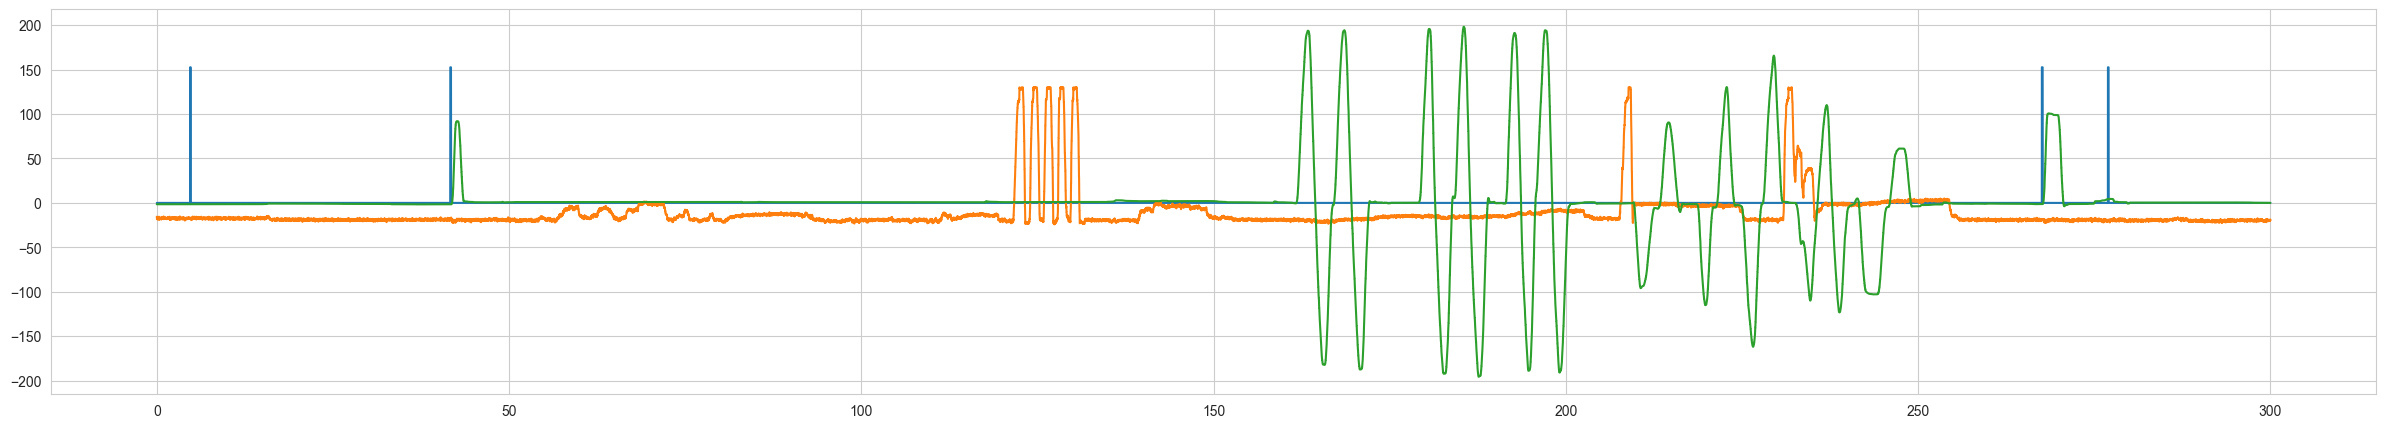

[473, 474, 475, 476, 477, 478, 479, 480, 481, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 27695, 27696, 27697, 27698, 27699, 27700, 27701, 27702, 27703, 27704]
473 30001


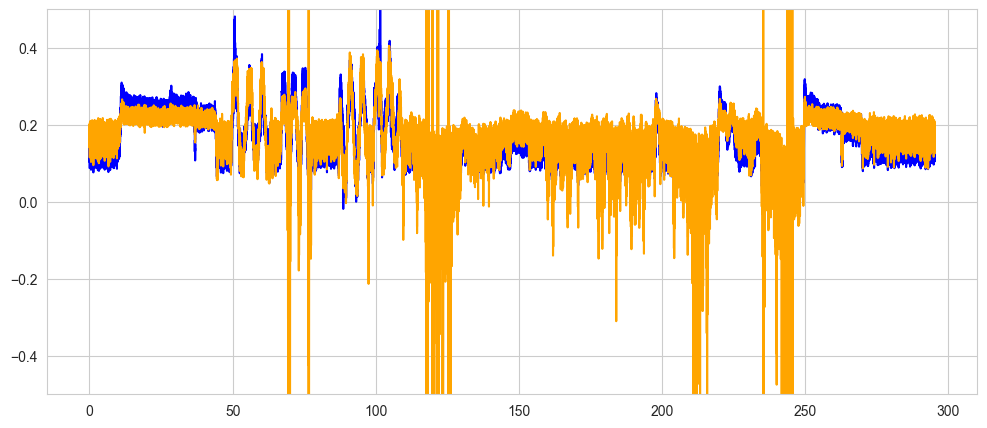

Sampling rate: 41.66666666666509 Hz


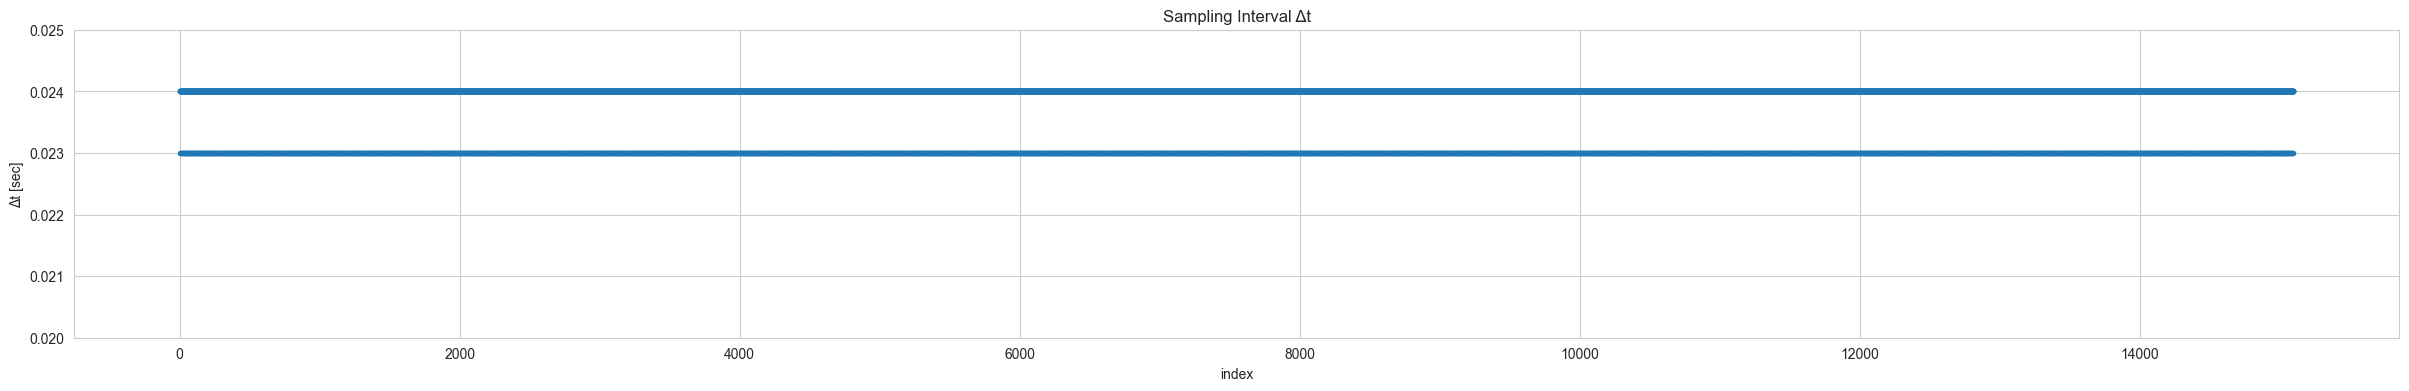

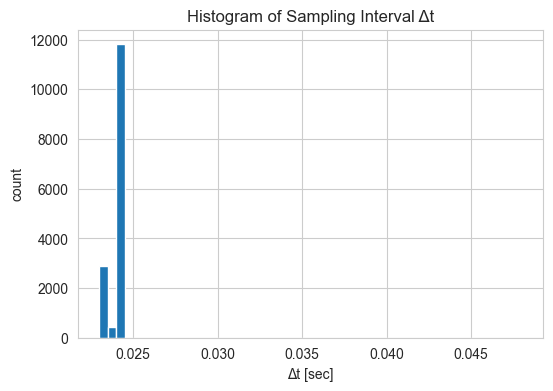

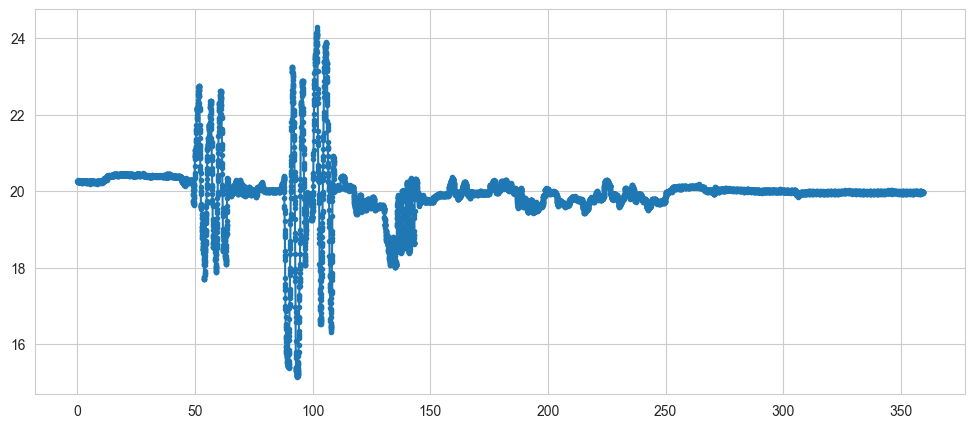

In [59]:
for num, idx in enumerate(data_info.index): 
    row = data_info.iloc[idx,:] 
    sub_ = row['sub'] 
    seat_path = row['seat']
    cop_path = row['cop']
    pedal_path = row['pedal']
    steer_path = row['steer']
    label = row['label']

    if (label != "3F") or (sub_ != "G"):
        continue

    df_seat = pd.read_csv(seat_path,skiprows=1)
    df_cop = pd.read_csv(cop_path,skiprows=21)
    df_pedal = pd.read_csv(pedal_path,skiprows=21)
    df_steer = pd.read_csv(steer_path,skiprows=21)

    if label == "2F":
        df_pedal.rename(columns={'Untitled 1':'pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 2':'trg'},inplace=True)
        df_cop.rename( columns={'Untitled 2':'COP_X','Untitled 3':'COP_Y'},inplace=True)

    elif label =="3F":
        df_pedal.rename(columns={'Untitled 2':'pedal','Untitled 5':'trg','Untitled':'timestamp','Untitled 7':'next_due_pedal'},inplace=True)
        df_steer.rename(columns={'Untitled 1':'steer','Untitled 7':'next_due_steer','Untitled':'timestamp'},inplace=True)
        df_cop.rename(columns={'Untitled':'F1','Untitled 1':'F2','Untitled 2':'F3','Untitled 3':'F4','Untitled 4':'FX','Untitled 5':'FY','Untitled 7':'next_due_seat'},inplace=True)


    df_pedal = make_time_row(df_pedal)
    df_steer = make_time_row(df_steer)
    df_cop = make_time_row(df_cop)
    
    df_mock = pd.merge(df_cop[['time','F1','F2','F3','F4','FX','FY']], df_steer[['time','steer']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 
    df_mock = pd.merge(df_mock, df_pedal[['time','pedal','trg']], on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 


    plt.figure(figsize=(30,5))
    plt.plot(df_mock.time,df_mock.trg*10)
    plt.plot(df_mock.time,df_mock.pedal*10)
    plt.plot(df_mock.time,df_mock.steer)
    plt.show()


    df_mock_tmp = get_first_trigger_segment(df_mock, trigger_col="trg", trigger_value=1)
    df_mock_tmp['time'] -= df_mock_tmp['time'].iloc[0]
    plt.plot(df_mock_tmp.time,df_mock_tmp['FY'],'-',color='blue')
    plt.plot(df_mock_tmp.time,df_mock_tmp['FX'],'-',color='orange')
    plt.ylim(-0.5,0.5)
    plt.show()

    df_seat = fix_columns(df_seat)
    df_seat['time'] = df_seat['時間_1']
    fs, dt = estimate_sampling_rate(df_seat)
    print("Sampling rate:", fs, "Hz")

    # time 差分（サンプリング間隔）
    dt = df_seat['time'].diff()

    plt.figure(figsize=(30,4))
    plt.plot(dt,'.')
    plt.title("Sampling Interval Δt")
    plt.xlabel("index")
    plt.ylabel("Δt [sec]")
    plt.ylim(0.020,0.025)
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(6,4))
    plt.hist(dt.dropna(), bins=50)
    plt.title("Histogram of Sampling Interval Δt")
    plt.xlabel("Δt [sec]")
    plt.ylabel("count")
    plt.grid(True)
    plt.show()

    plt.plot(df_seat.time,df_seat['圧力中心列_2'],'.-')

    
    # break


--- Processing Start ---
Column 'FX' (Thresh=5.0): Detected 34 outliers.
Column 'FY' (Thresh=1.0): Detected 0 outliers.
--- Processing End ---



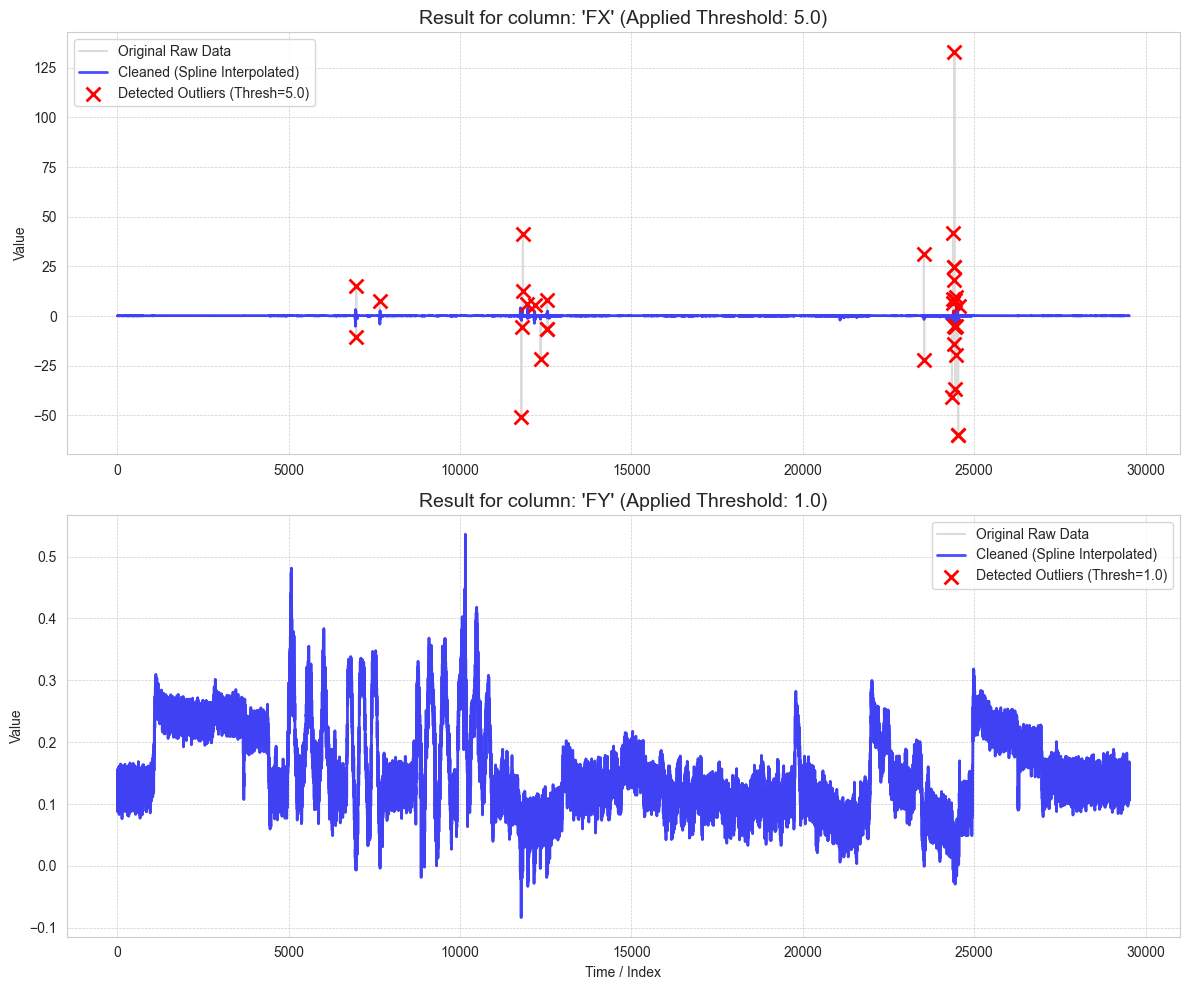

In [60]:
# --- 修正済みの関数 ---
def clean_outliers_spline_multi(df_input, threshold_dict, window=11):
    """
    カラムごとに異なる閾値で外れ値を検知し、スプライン補間で埋める関数。
    (インデックス重複や不整合によるエラーを回避する .values 版)
    """
    # 元データを変更しないようコピー
    df_result = df_input.copy()
    
    for col, thresh in threshold_dict.items():
        if col not in df_result.columns:
            continue

        # 1. トレンド推定（Seriesのまま計算）
        # rollingはインデックスを維持するため、そのまま使います
        rolling_obj = df_result[col].rolling(window=window, center=True)
        rolling_median = rolling_obj.median()
        
        # 2. 残差スコア計算 & 3. 閾値判定
        # 【重要修正ポイント】 .values をつけて Numpy配列同士として計算します。
        # これによりインデックスの不整合によるエラーを回避します。
        diff = df_result[col].values - rolling_median.values
        score = np.abs(diff)
        
        # マスクもNumpy配列(True/Falseのリスト)になります
        outlier_mask = score > thresh
        
        # ログ表示（numpyのsumを使います）
        n_outliers = np.sum(outlier_mask) 
        print(f"Column '{col}' (Thresh={thresh}): Detected {n_outliers} outliers.")
        
        if n_outliers > 0:
            # 4. 外れ値をNaNに置換
            # .loc は Numpy配列のマスク(True/False)をそのまま受け取れます
            df_result.loc[outlier_mask, col] = np.nan
            
            # 5. スプライン補間
            # limit_direction='both'で端も埋めます
            df_result[col] = df_result[col].interpolate(method='spline', order=3, limit_direction='both')
            
    return df_result

# ==========================================
#  実行と確認プロット
# ==========================================

# 1. テスト用データの作成（正常な時系列データ）
# np.random.seed(42)
# t = np.linspace(0, 100, 300) # 点数を少し増やして滑らかに

# # カラムA (FX): 変動が小さいデータ
# col_a = np.sin(t / 5) + np.random.normal(0, 0.1, 300)
# col_a[50] = 4.5   # 上スパイク
# col_a[120] = -3.5 # 下スパイク

# # カラムB (Sensor): 変動が激しいデータ（振幅が大きい）
# col_b = 5 * np.cos(t / 5) + np.random.normal(0, 0.5, 300) 
# col_b[200] = 18.0 # 巨大なスパイク
# col_b[205:210] = -15.0 # 幅のある異常

# df_mock = pd.DataFrame({'FX': col_a, 'Sensor': col_b}, index=t)

# 2. 設定（辞書で閾値を個別指定）
# FXは厳しく(1.0)、Sensorは緩く(4.0)
settings = {
    'FX': 5.0,
    'FY': 1.0 
}

# 3. 関数を実行（修正済み関数を使用）
print("--- Processing Start ---")
df_cleaned = clean_outliers_spline_multi(df_mock_tmp, threshold_dict=settings, window=15)
print("--- Processing End ---\n")

# --- 復活させた結果確認プロット ---
fig, axes = plt.subplots(len(settings), 1, figsize=(12, 10))

# 辞書のキー（カラム名）を使って順番にプロット
for i, col in enumerate(settings.keys()):
    # 元データ（薄いグレーで表示）
    axes[i].plot(df_mock_tmp.index, df_mock_tmp[col], label='Original Raw Data', color='lightgray', alpha=0.8, linewidth=1.5)
    
    # 補間後データ（青色で表示）
    axes[i].plot(df_cleaned.index, df_cleaned[col], label='Cleaned (Spline Interpolated)', color='blue', linewidth=2, alpha=0.7)
    
    # 除去された点（赤いバツ印で強調）
    # 元データと補間後データが異なる場所を探します
    removed_points = df_mock_tmp[df_mock_tmp[col] != df_cleaned[col]]
    axes[i].scatter(removed_points.index, removed_points[col], color='red', marker='x', s=100, linewidth=2, label=f'Detected Outliers (Thresh={settings[col]})', zorder=5)
    
    # グラフの体裁を整える
    axes[i].set_title(f"Result for column: '{col}' (Applied Threshold: {settings[col]})", fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_ylabel('Value')

axes[-1].set_xlabel('Time / Index')
plt.tight_layout()
plt.show()

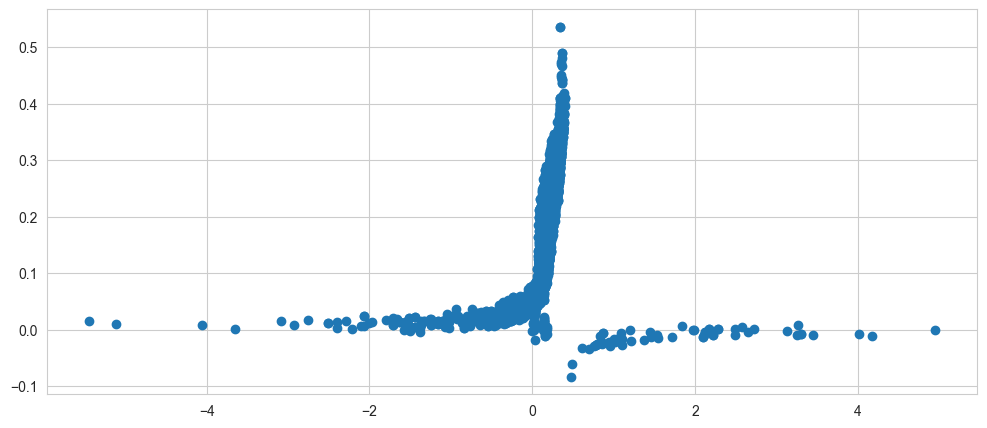

In [61]:
plt.scatter(df_cleaned.FX,df_cleaned.FY)

# ずれ量探索

['time', 'F1', 'F2', 'F3', 'F4', 'FX', 'FY', 'steer', 'pedal', 'trg', 'FX_filtered', 'FY_filtered']


C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12501 (\N{KATAKANA LETTER HU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\1500078414.py:115: UserWarning: Glyph 12469 (\N{KATAKANA LETTER SA}) missing from font(s) Arial.
  plt

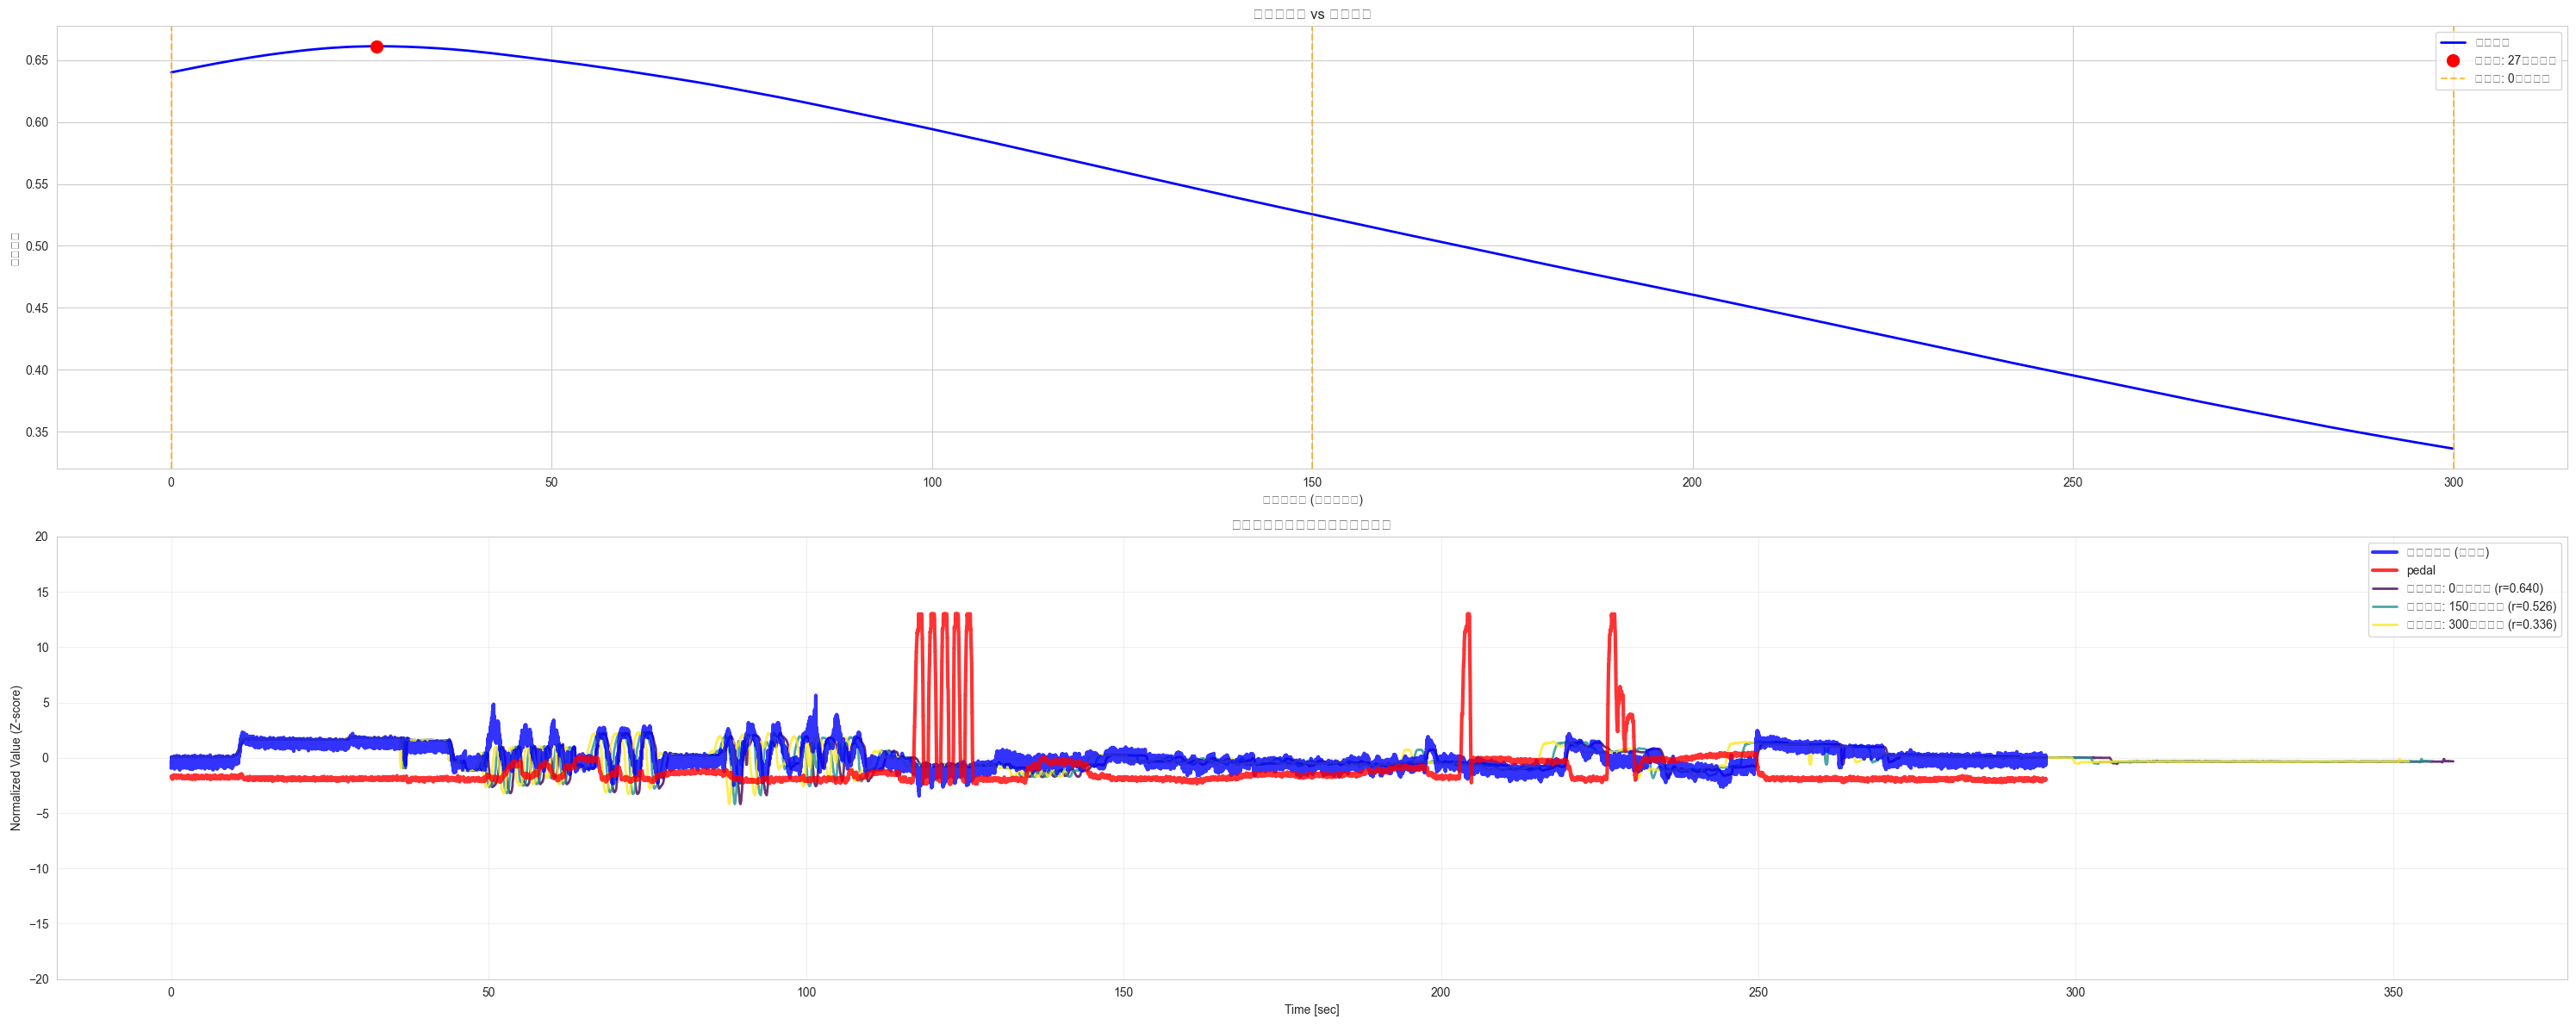


=== 探索結果サマリー ===
探索範囲: 0 ~ 300 サンプル
最適なドリフト量: 27 サンプル
最大相関係数: 0.6611

=== 代表サンプル詳細 ===
   ドリフト   0 サンプル: 相関係数 = 0.6400
   ドリフト 150 サンプル: 相関係数 = 0.5255
   ドリフト 300 サンプル: 相関係数 = 0.3363


In [62]:
def evaluate_linear_drifts_with_samples(df_ref, df_target, drift_range, 
                                       col_ref='COP_X', col_target='圧力中心列_2',
                                       num_sample_views=3):
    """
    線形ドリフトの評価＋代表的なサンプルを時系列グラフで表示
    """
    
    # --- 1. 前処理: 正規化 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    # --- 2. 時間軸計算の準備 ---
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start # 全体長さ
    
    # --- 3. 全範囲で相関計算 ---
    all_results = []
    for drift_samples in range(drift_range[0], drift_range[1] + 1):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # 補間
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 相関計算
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
        else:
            correlation = -1
            
        all_results.append((drift_samples, correlation))
    
    # 結果をソート
    all_results.sort(key=lambda x: x[0])
    drifts, corrs = zip(*all_results)
    
    # --- 4. 代表サンプルの選択 ---
    if len(drifts) <= num_sample_views:
        sample_drifts = drifts
    else:
        # 最小、中央、最大から選択
        indices = [
            0,  # 最小
            len(drifts) // 2,  # 中央
            len(drifts) - 1  # 最大
        ]
        sample_drifts = [drifts[i] for i in indices]
    
    # --- 5. 可視化 ---
    fig = plt.figure(figsize=(30, 12))
    
    # 5-1. 相関グラフ
    ax1 = plt.subplot(2, 1, 1)
    best_idx = np.argmax(corrs)
    plt.plot(drifts, corrs, 'b-', linewidth=2, label='相関係数')
    plt.plot(drifts[best_idx], corrs[best_idx], 'ro', markersize=10, 
             label=f'最適点: {drifts[best_idx]}サンプル')
    
    # 代表サンプルを縦線で表示
    for drift in sample_drifts:
        idx = drifts.index(drift)
        plt.axvline(x=drift, color='orange', linestyle='--', alpha=0.7,
                   label=f'代表点: {drift}サンプル' if drift == sample_drifts[0] else "")
    
    plt.xlabel('ドリフト量 (サンプル数)')
    plt.ylabel('相関係数')
    plt.title('ドリフト量 vs 相関係数')
    plt.grid(True)
    plt.legend()
    
    # 5-2. 時系列比較グラフ
    ax2 = plt.subplot(2, 1, 2)
    
    # 参照データ
    plt.plot(df_ref['time'], ref_norm, color='blue', linewidth=3, 
             alpha=0.8, label='参照データ (正規化)', zorder=10)
    plt.plot(df_ref['time'], df_ref['pedal'], color='red', linewidth=3, 
             alpha=0.8, label='pedal', zorder=10)
    
    # カラーマップ
    colors = plt.cm.viridis(np.linspace(0, 1, len(sample_drifts)))
    
    # 各代表サンプルの時系列をプロット
    for i, drift_samples in enumerate(sample_drifts):
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        
        # このドリフト量での相関係数を検索
        drift_corr = next((corr for drift, corr in all_results if drift == drift_samples), 0)
        
        plt.plot(new_time, target_norm, 
                 color=colors[i], linewidth=2, alpha=0.8,
                 label=f'ドリフト: {drift_samples}サンプル (r={drift_corr:.3f})')
    
    plt.title('代表的なドリフト量の時系列比較')
    plt.xlabel('Time [sec]')
    plt.ylabel('Normalized Value (Z-score)')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # 後半部分を拡大表示
    # plt.xlim(200, 300)
    plt.ylim(-20, 20)
    
    plt.tight_layout()
    plt.show()
    
    # --- 6. 結果表示 ---
    print("\n=== 探索結果サマリー ===")
    print(f"探索範囲: {drift_range[0]} ~ {drift_range[1]} サンプル")
    print(f"最適なドリフト量: {drifts[best_idx]} サンプル")
    print(f"最大相関係数: {corrs[best_idx]:.4f}")
    
    print(f"\n=== 代表サンプル詳細 ===")
    for drift in sample_drifts:
        idx = drifts.index(drift)
        marker = "★" if drift == drifts[best_idx] else "  "
        print(f"{marker} ドリフト {drift:3d} サンプル: 相関係数 = {corrs[idx]:.4f}")
    
    return all_results, sample_drifts

# ==========================================
# 実行例
# ==========================================

filter_processor = DataFrameLowpassFilter(
    sampling_freq=100, 
    cutoff_freq=5, 
    order=1
)

# 複数列を一度にフィルタリング
columns_to_process = ['FX', 'FY']
df_filtered = filter_processor.filter_dataframe(df_cleaned, columns_to_process)

print(df_filtered.columns.tolist())


all_results, sample_drifts = evaluate_linear_drifts_with_samples(
    df_filtered, #df_cleaned,
    df_seat, 
    drift_range=[0,300],  # 探索範囲
    # col_ref='FY_filtered',
    # col_target='荷重(N)_1',

    col_ref='FY', 
    col_target='圧力中心行_1',
    num_sample_views=3  # 表示する代表点の数
)

# リサンプリングパラメータあてはめ

C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\youli\AppData\Local\Temp\ipykernel_27576\152420524.py:87: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missi

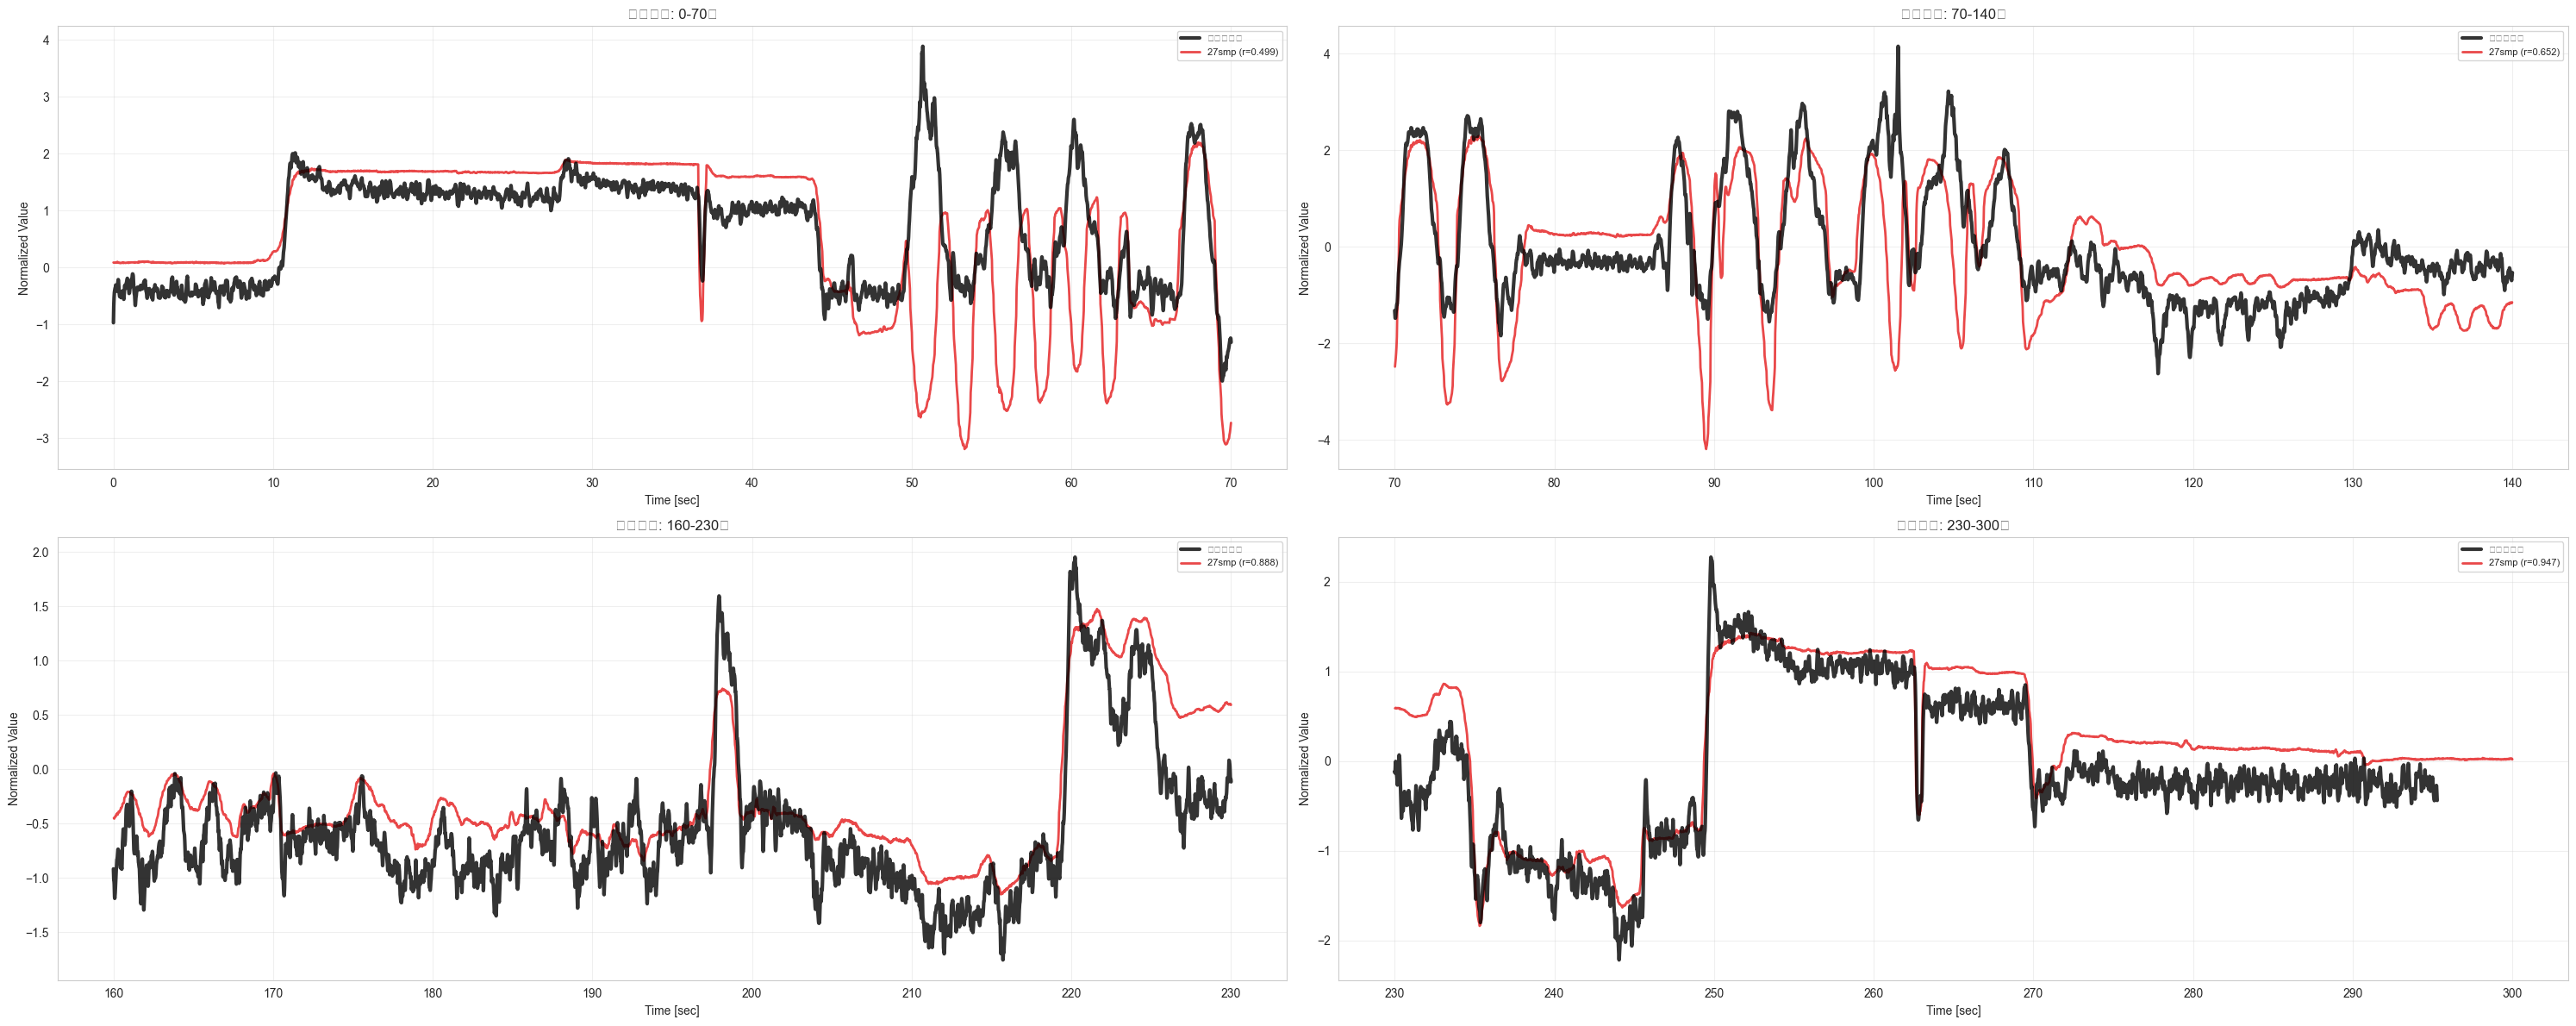


=== 指定ドリフト量の全体相関 ===
ドリフト  27 サンプル: 全体相関 = 0.6921


In [63]:
def compare_detailed_samples(df_ref, df_target, specific_drifts, 
                           col_ref='COP_X', col_target='圧力中心列_2',
                           focus_range=(200, 300)):
    """
    特定のドリフト量を詳細に比較（複数区間で表示）
    """    

    # --- 前処理 ---
    ref_data = df_ref[col_ref]
    ref_norm = (ref_data - ref_data.mean()) / ref_data.std()
    
    target_data = df_target[col_target]
    target_norm = (target_data - target_data.mean()) / target_data.std()
    
    dt_mean = df_target['time'].diff().mean()
    t_start = df_target['time'].min()
    t_end_orig = df_target['time'].max()
    duration = t_end_orig - t_start
    
    # --- 複数サブプロットで表示 ---
    fig, axes = plt.subplots(2, 2, figsize=(30, 12))
    axes = axes.flatten()
    
    # カラーマップ
    colors = plt.cm.Set1(np.linspace(0, 1, len(specific_drifts)))
    
    # 各注目区間をプロット
    focus_ranges = [
        (0, 70),     # 最初の部分
        (70, 140),   # 前半部分
        (160, 230),  # 中間部分
        (230, 300),  # 後半部分
    ]
    
    for ax_idx, (start_time, end_time) in enumerate(focus_ranges):
        if ax_idx >= len(axes):
            break
            
        ax = axes[ax_idx]
        
        # 参照データ
        mask_ref = (df_ref['time'] >= start_time) & (df_ref['time'] <= end_time)
        ax.plot(df_ref['time'][mask_ref], ref_norm[mask_ref], 
                color='black', linewidth=3, alpha=0.8, 
                label='参照データ', zorder=10)
        
        # 各ドリフト量
        for i, drift_samples in enumerate(specific_drifts):
            total_lag_time = drift_samples * dt_mean
            scale_factor = duration / (duration + total_lag_time)
            new_time = t_start + (df_target['time'] - t_start) * scale_factor
            
            # 相関係数計算（この区間のみ）
            mask_target = (new_time >= start_time) & (new_time <= end_time)
            if np.sum(mask_target) > 5:
                # この区間内での相関を計算
                time_in_range = new_time[mask_target]
                values_in_range = target_norm[mask_target]
                
                # 参照データと同じ時間点に補間
                from scipy import interpolate
                f_interp = interpolate.interp1d(time_in_range, values_in_range, 
                                              bounds_error=False, fill_value='extrapolate')
                target_aligned = f_interp(df_ref['time'][mask_ref])
                
                # 相関計算
                valid_mask = ~np.isnan(target_aligned)
                if np.sum(valid_mask) > 5:
                    correlation = np.corrcoef(ref_norm[mask_ref][valid_mask], 
                                            target_aligned[valid_mask])[0,1]
                else:
                    correlation = 0
            else:
                correlation = 0
            
            # プロット
            ax.plot(new_time[mask_target], target_norm[mask_target],
                   color=colors[i], linewidth=2, alpha=0.8,
                   label=f'{drift_samples}smp (r={correlation:.3f})')
        
        ax.set_title(f'時間範囲: {start_time}-{end_time}秒')
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('Normalized Value')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # 各ドリフト量の全体相関も表示
    print("\n=== 指定ドリフト量の全体相関 ===")
    for drift_samples in specific_drifts:
        total_lag_time = drift_samples * dt_mean
        scale_factor = duration / (duration + total_lag_time)
        new_time = t_start + (df_target['time'] - t_start) * scale_factor
        # new_time = df_target['time'] * scale_factor
        
        # 補間
        from scipy import interpolate
        f_interp = interpolate.interp1d(new_time, target_norm, 
                                      bounds_error=False, fill_value='extrapolate')
        target_aligned = f_interp(df_ref['time'])
        
        # 全体相関
        valid_mask = ~np.isnan(target_aligned)
        if np.sum(valid_mask) > 10:
            overall_correlation = np.corrcoef(ref_norm[valid_mask], target_aligned[valid_mask])[0,1]
            print(f"ドリフト {drift_samples:3d} サンプル: 全体相関 = {overall_correlation:.4f}")

# 特定のドリフト量を詳細比較
compare_detailed_samples(
    df_filtered, # df_cleaned, 
    df_seat, 
    specific_drifts=[27],  # 比較したい特定の値 subA = 279 subC = 140, subE = 269, subG = 27
    # col_ref='FY_filtered', 
    # col_target='荷重(N)_1'

    col_ref='FY_filtered', 
    col_target='圧力中心行_1'

    # col_ref='FX_filtered', 
    # col_target='圧力中心列_1'


)

# ずれ量確定

補正情報:
  - ズレサンプル数: 27
  - ズレ時間換算  : 0.6429 sec
  - 適用スケール  : 0.99821464


c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32080 (\N{CJK UNIFIED IDEOGRAPH-7D50}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing fr

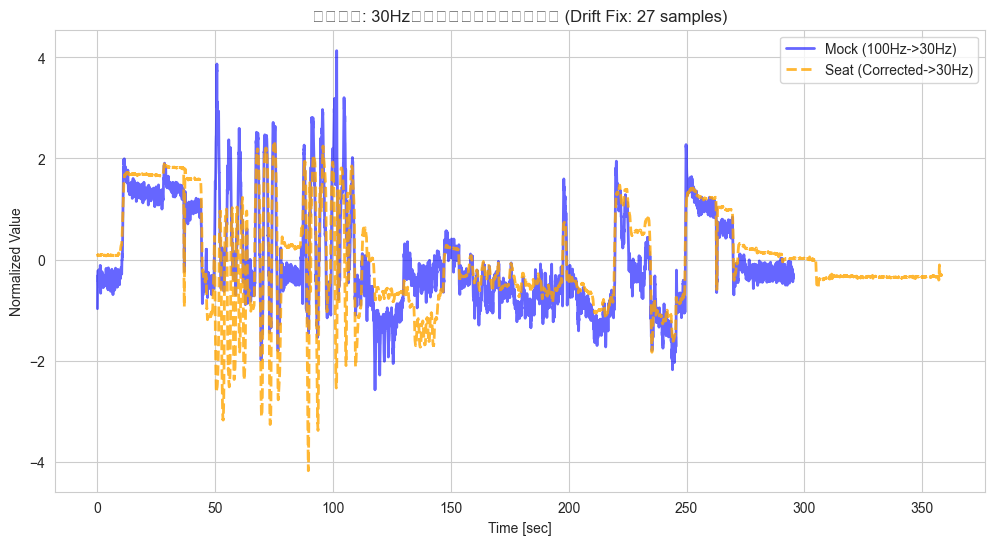

--- df_mock_30hz ---
       time        F1        F2        F3        F4    steer     pedal  \
0  0.000000 -0.036621  0.312805  0.634766  0.353088 -1.51751 -1.709473   
1  0.033333  0.006104  0.374756  0.568848  0.269470 -1.51751 -1.801026   
2  0.066667  0.063883  0.373942  0.619710  0.262146 -1.51751 -1.770508   
3  0.100000  0.076904  0.361328  0.592346  0.239563 -1.51751 -1.678956   
4  0.133333  0.095113  0.356547  0.582377  0.282186 -1.51751 -1.709473   

   FX_filtered  FY_filtered  
0     0.116631     0.088345  
1     0.149327     0.114331  
2     0.164747     0.124116  
3     0.172589     0.127372  
4     0.177202     0.130677  

--- df_seat_30hz ---
       time  平均圧力_1  最低圧力_1   ピーク圧力_1  接触域 (cm²)_1  選択領域(cm²)_1     接触 %_1  \
0  0.000000     0.4    0.13  2.080000   879.030000      2580.65  34.060000   
1  0.033333     0.4    0.13  2.082173   879.030000      2580.65  34.060000   
2  0.066667     0.4    0.13  2.078168   879.030000      2580.65  34.060000   
3  0.100000     0.4 

In [64]:
# =========================================================
# 1. パラメータ設定
# =========================================================
BEST_DRIFT_SAMPLES = 27  # 見つけたベストな値
TARGET_FS = 30.0           # 目標サンプリング周波数 (Hz)

# =========================================================
# 2. df_seat の時間軸を補正（永続化）
# =========================================================
def apply_drift_correction(df, drift_samples):
    """
    見つけたドリフト量(samples)に基づいて時間軸を実際に書き換える
    """
    df_fixed = df.copy()
    
    # 統計量の計算
    dt_mean = df_fixed['time'].diff().mean()
    t_start = df_fixed['time'].min()
    t_end   = df_fixed['time'].max()
    duration = t_end - t_start
    
    # ズレ時間の計算 (35サンプル * 1サンプルの時間)
    total_lag_time = drift_samples * dt_mean
    
    # 伸縮率 (Scale Factor) の計算
    # visualize関数と同じ計算式を使用
    scale_factor = duration / (duration + total_lag_time)
    
    print(f"補正情報:")
    print(f"  - ズレサンプル数: {drift_samples}")
    print(f"  - ズレ時間換算  : {total_lag_time:.4f} sec")
    print(f"  - 適用スケール  : {scale_factor:.8f}")
    
    # 時間軸の更新
    df_fixed['time'] = t_start + (df_fixed['time'] - t_start) * scale_factor
    
    return df_fixed

# df_seat の時間を修正
df_seat_fixed = apply_drift_correction(df_seat, BEST_DRIFT_SAMPLES)


# =========================================================
# 3. 共通の30Hzへのリサンプリング
# =========================================================
def resample_to_target_hz(df, time_col, data_cols, target_fs):
    """
    指定されたDataFrameをtarget_fs(Hz)にリサンプリングする関数
    """
    # 元データ
    t_src = df[time_col].values
    # 時間軸の開始と終了（データの範囲内）
    t_min, t_max = t_src.min(), t_src.max()
    
    # 新しい時間軸 (startからendまで 1/fs 刻み)
    new_time = np.arange(t_min, t_max, 1.0 / target_fs)
    
    # 結果格納用DataFrame
    df_resampled = pd.DataFrame({time_col: new_time})
    
    # 指定されたデータ列を補間
    for col in data_cols:
        # 線形補間 (linear) または 3次スプライン (cubic)
        f = interpolate.interp1d(t_src, df[col].values, kind='linear', fill_value="extrapolate")
        df_resampled[col] = f(new_time)
        
    return df_resampled

# --- リサンプリング実行 ---

mock_cols = ['F1', 'F2', 'F3', 'F4', 'steer', 'pedal', 'FX_filtered', 'FY_filtered']
seat_cols = ['平均圧力_1', '最低圧力_1',
       'ピーク圧力_1', '接触域 (cm²)_1', '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1',
       '平均_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2',
       '接触域 (cm²)_2', '選択領域(cm²)_2', '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2',
       '圧力中心行_2', '圧力中心列_2']

# df_mock_tmp (元100Hz) -> 30Hz
df_mock_30hz = resample_to_target_hz(
    df_filtered, 
    time_col='time', 
    data_cols=mock_cols, # 必要な列を指定
    target_fs=TARGET_FS
)

# df_seat_fixed (補正済み40Hz) -> 30Hz
df_seat_30hz = resample_to_target_hz(
    df_seat_fixed, 
    time_col='time', 
    data_cols=seat_cols, # 必要な列を指定
    target_fs=TARGET_FS
)


# =========================================================
# 4. 結果の確認（結合・プロット）
# =========================================================

# 時間軸を完全に合わせるため、共通の時間範囲でデータを結合（Merge）しても良いですが、
# ここではプロットで確認します。

# 正規化関数（比較用）
def z_score(series):
    return (series - series.mean()) / series.std()

plt.figure(figsize=(12, 6))

# 青: df_mock (30Hz)
plt.plot(df_mock_30hz['time'], z_score(df_mock_30hz['FY_filtered']), 
         label='Mock (100Hz->30Hz)', color='blue', alpha=0.6, linewidth=2)

# オレンジ: df_seat (補正済み->30Hz)
plt.plot(df_seat_30hz['time'], z_score(df_seat_30hz['圧力中心行_1']), 
         label='Seat (Corrected->30Hz)', color='orange', alpha=0.8, linestyle='--', linewidth=2)

plt.title(f"最終結果: 30Hz同期・リサンプリング完了 (Drift Fix: {BEST_DRIFT_SAMPLES} samples)")
plt.xlabel("Time [sec]")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)

# ズレやすい後半を拡大
t_end = df_mock_30hz['time'].max()
# plt.xlim(t_end - 10, t_end) 

plt.show()

# データフレームの中身確認
print("--- df_mock_30hz ---")
print(df_mock_30hz.head())
print("\n--- df_seat_30hz ---")
print(df_seat_30hz.head())

c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33655 (\N{CJK UNIFIED IDEOGRAPH-8377}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


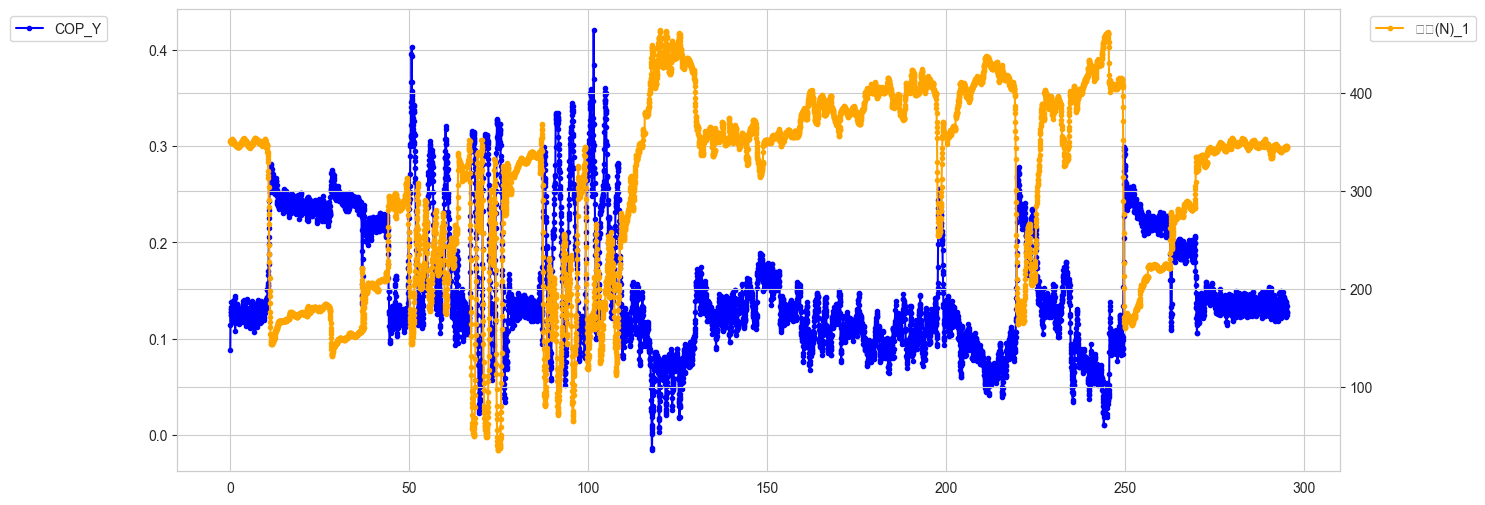

c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22311 (\N{CJK UNIFIED IDEOGRAPH-5727}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24515 (\N{CJK UNIFIED IDEOGRAPH-5FC3}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\youli\Desktop\code\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing fr

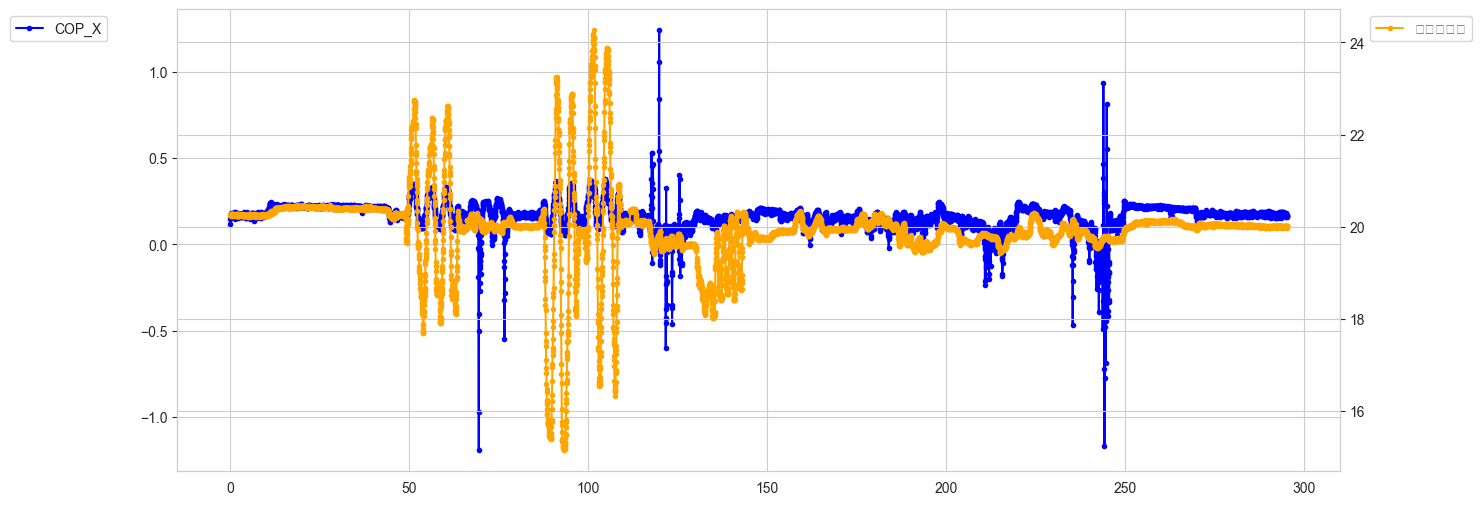

In [ ]:
df_all = pd.merge(df_mock_30hz, df_seat_30hz, on='time', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)') 

# import pickle
# df_all['subject_id'] = 7
# with open('G.pkl','wb') as f:
#     pickle.dump(df_all,f)


fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all.time,df_all['FY_filtered'],'.-',color='blue',label='COP_Y')
ax2.plot(df_all['time'],df_all['荷重(N)_1'],'.-',color='orange',label='荷重(N)_1') 
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx() 
ax1.plot(df_all["time"],df_all['FX_filtered'],'.-',color='blue',label='COP_X')
ax2.plot(df_all['time'],df_all['圧力中心列_2'],'.-',color='orange',label='圧力中心列') # Y
ax1.legend(bbox_to_anchor=(-0.15, 1.0), loc='upper left')
ax2.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

# ここから

In [9]:
import pickle

dfs = []

for ch in ['A','C', 'E', 'G']:
    fname = f"{ch}.pkl"
    with open(fname, "rb") as f:
        df = pickle.load(f)
        dfs.append(df)

# 縦に連結
df_all = pd.concat(dfs, axis=0, ignore_index=True)


In [10]:

# 定数（座面寸法）
FR = 0.454  # 前後方向 [m]
LR = 0.43   # 左右方向 [m]
# 合計荷重
df_all["W"] = df_all["F1"] + df_all["F2"] + df_all["F3"] + df_all["F4"]
# ゼロ割対策（荷重ゼロのときはNaNにする）
W = df_all["W"].replace(0, np.nan)
# --- COP X（前後方向） ---
df_all["COP_X_phys"] = ( df_all["F1"]*(+FR/2) + df_all["F2"]*(+FR/2) + df_all["F3"]*(-FR/2) + df_all["F4"]*(-FR/2)) / W
# --- COP Y（左右方向） ---
df_all["COP_Y_phys"] = ( df_all["F1"]*(+LR/2) + df_all["F2"]*(-LR/2) + df_all["F3"]*(+LR/2) + df_all["F4"]*(-LR/2)) / W

df_all['phys_pitch'] = (df_all['F1'] + df_all['F2']) - (df_all['F3'] + df_all['F4']) # 前 - 後
df_all['phys_roll']  = (df_all['F1'] + df_all['F3']) - (df_all['F2'] + df_all['F4']) # 左 - 右
df_all['phys_torsion'] = (df_all['F1'] + df_all['F4']) - (df_all['F2'] + df_all['F3']) # 対角差（ねじれ）
df_all['COP_radius'] = np.sqrt(df_all['COP_X_phys']**2 + df_all['COP_Y_phys']**2)
df_all['COP_angle'] = np.arctan2(df_all['COP_Y_phys'], df_all['COP_X_phys'])
df_all['op_magnitude'] = np.sqrt(df_all['steer']**2 + df_all['pedal']**2)
df_all['steer_COPx'] = df_all['steer'] * df_all['COP_X_phys']
df_all['steer_COPy'] = df_all['steer'] * df_all['COP_Y_phys']
df_all['pedal_COPx'] = df_all['pedal'] * df_all['COP_X_phys']
df_all['pedal_COPy'] = df_all['pedal'] * df_all['COP_Y_phys']

df_all['interact_steer_pedal'] = df_all['steer'] * df_all['pedal']
df_all['op_magnitude'] = np.sqrt(df_all['steer']**2 + df_all['pedal']**2)

# 欠損値（W=0のときなど）を0で埋める
df_all = df_all.fillna(0)
            

In [11]:
df_all.columns

Index(['time', 'F1', 'F2', 'F3', 'F4', 'steer', 'pedal', 'FX_filtered',
       'FY_filtered', '平均圧力_1', '最低圧力_1', 'ピーク圧力_1', '接触域 (cm²)_1',
       '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1', '平均_1', '圧力中心行_1',
       '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2', '接触域 (cm²)_2', '選択領域(cm²)_2',
       '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2', '圧力中心行_2', '圧力中心列_2',
       'subject_id', 'W', 'COP_X_phys', 'COP_Y_phys', 'phys_pitch',
       'phys_roll', 'phys_torsion', 'COP_radius', 'COP_angle', 'op_magnitude',
       'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy',
       'interact_steer_pedal'],
      dtype='object')

# 見せかけの回帰対策

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# ==========================================
# 1. SubjectAwareSmoother (平滑化)
# ==========================================
class SubjectAwareSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, window=15):
        self.window = window

    def _apply_rolling_mean(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            X_smooth_full = self._apply_rolling_mean(X_combined)
            X_smooth = X_smooth_full.iloc[-len(X):]
        else:
            X_smooth = self._apply_rolling_mean(X)
        
        X_out[target_cols] = X_smooth
        return X_out

# ==========================================
# 2. SubjectAwareDetrender (トレンド除去)
# ==========================================
class SubjectAwareDetrender(BaseEstimator, TransformerMixin):
    def __init__(self, window=300):
        self.window = window

    def _calculate_trend(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            trend_full = self._calculate_trend(X_combined)
            trend = trend_full.iloc[-len(X):]
        else:
            trend = self._calculate_trend(X)

        X_out[target_cols] = X_out[target_cols] - trend
        return X_out

# ==========================================
# SubjectAwareDifferencer (差分化)
# ==========================================
class SubjectAwareDifferencer(BaseEstimator, TransformerMixin):
    """
    Subjectごとに1階差分(Diff)をとるクラス
    Test時はContextを受け取り、境界値のDiffも正しく計算する
    """
    def __init__(self):
        pass

    def _apply_diff(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_diff = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_diff].diff()
        
        # GroupBy Diff
        diffed = df.groupby('subject_id')[cols_to_diff].diff()
        # diffの結果はindexが維持されるのでそのまま返す
        return diffed

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            # Context結合 (diffには直前1行あればいいが、念のため少し多めに)
            X_combined = pd.concat([X_context.iloc[-5:], X])
            diff_full = self._apply_diff(X_combined)
            diff = diff_full.iloc[-len(X):]
        else:
            diff = self._apply_diff(X)
        
        X_out[target_cols] = diff
        return X_out


# ==========================================
# 3. CausalFeatureGenerator (ラグ特徴量生成)
# ==========================================
class CausalFeatureGenerator:
    def __init__(self, control_lags):
        self.control_lags = control_lags

    def transform(self, X, y_target_col):
        features_df = pd.DataFrame(index=X.index)
        
        if 'subject_id' not in X.columns:
            groups = X.assign(temp_id=1).groupby('temp_id')
        else:
            groups = X.groupby('subject_id')

        # 使用する特徴量候補
        feature_vars = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','COP_X_phys','COP_Y_phys','pedal','steer','interact_steer_pedal',
       'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius',
       'COP_angle', 'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy']
        
        for feature_var in feature_vars:
            if feature_var not in X.columns: continue
            
            control_key = f"{feature_var}→{y_target_col}"
            optimal_lag = self.control_lags.get(control_key, 0)
            
            # 指定ラグ周辺を含めて生成
            # for lag in range(1, optimal_lag + 10):
            #     features_df[f"{feature_var}_lag{lag}"] = groups[feature_var].shift(lag)

            # 1. 探索範囲を決める (例: 最適値の前後5ポイント)
            # ※ optimal_lag が 0 の場合は、何もしないか、直近だけ取る
            if optimal_lag == 0:
                lags_to_generate = [1] # デフォルト
            else:
                # 下限は必ず 1以上 (未来を見ないため)
                start_lag = max(1, optimal_lag - 5)
                end_lag   = optimal_lag + 5
                
                # 範囲生成
                lags_to_generate = range(start_lag, end_lag + 1)

            # 2. 指定されたラグだけを生成
            for lag in lags_to_generate:
                col_name = f"{feature_var}_lag{lag}"
                features_df[col_name] = groups[feature_var].shift(lag)

        return features_df

# ==========================================
# 4. SubjectAwareStandardizer (標準化)
# ==========================================
class SubjectAwareStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stats_per_subject = {} 
        self.global_stats = {}      
        self.target_cols = []

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.target_cols = [c for c in numeric_cols if c != 'subject_id']

        # 1. Global Stats
        for col in self.target_cols:
            mean, std = X[col].mean(), X[col].std()
            if std == 0: std = 1.0
            self.global_stats[col] = (mean, std)

        # 2. Subject Stats
        if 'subject_id' in X.columns:
            grouped = X.groupby('subject_id')[self.target_cols].agg(['mean', 'std'])
            for subject_id, row in grouped.iterrows():
                self.stats_per_subject[subject_id] = {}
                for col in self.target_cols:
                    m = row[(col, 'mean')]
                    s = row[(col, 'std')]
                    if pd.isna(s) or s == 0: s = 1.0
                    self.stats_per_subject[subject_id][col] = (m, s)
        return self

    def transform(self, X):
        X_out = X.copy()
        
        # Subjectが無い場合
        if 'subject_id' not in X.columns:
            for col in self.target_cols:
                if col in X_out.columns:
                    m, s = self.global_stats[col]
                    X_out[col] = (X_out[col] - m) / s
            return X_out

        # Subjectがある場合 (Mapによる高速化)
        for col in self.target_cols:
            if col not in X_out.columns: continue

            mean_map, std_map = {}, {}
            g_mean, g_std = self.global_stats[col]

            for uid in X_out['subject_id'].unique():
                if uid in self.stats_per_subject:
                    mean_map[uid] = self.stats_per_subject[uid][col][0]
                    std_map[uid]  = self.stats_per_subject[uid][col][1]
                else:
                    mean_map[uid] = g_mean
                    std_map[uid]  = g_std
            
            means = X_out['subject_id'].map(mean_map)
            stds  = X_out['subject_id'].map(std_map)
            X_out[col] = (X_out[col] - means) / stds

        return X_out

# ==========================================
# 5. SimplePLSModel
# ==========================================
class SimplePLSModel:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = None

    def fit(self, X, y):
        self.model = PLSRegression(n_components=min(self.n_components, X.shape[1]))
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


from sklearn.model_selection import KFold, GroupKFold, cross_val_score

class AutoTunedPLSModel:
    def __init__(self, max_components=30, cv_splits=5, cv_method='random'):
        """
        cv_method: 'random' (KFold) or 'group' (GroupKFold)
        """
        self.max_components = max_components
        self.cv_splits = cv_splits
        self.cv_method = cv_method
        self.best_n_components_ = None
        self.model = None

    def fit(self, X, y, groups=None):
        """
        groups: Inner CVで GroupKFold を使うためのグルーピング情報 (subject_id等)
        """
        # 探索範囲
        n_features = X.shape[1]
        limit = min(n_features, self.max_components)
        if limit < 1: limit = 1
        candidate_components = range(1, limit + 1)
        
        best_score = float('inf')
        best_n = 1
        
        # CV分割器の選択
        if self.cv_method == 'group':
            if groups is None:
                raise ValueError("cv_method='group' requires 'groups' argument in fit().")
            
            # グループ数がsplit数より少ない場合の安全策
            n_groups = len(np.unique(groups))
            actual_splits = min(self.cv_splits, n_groups)
            
            cv = GroupKFold(n_splits=actual_splits)
        else:
            # ランダム分割 (従来通り)
            cv = KFold(n_splits=self.cv_splits, shuffle=True, random_state=42)
        
        # グリッドサーチ
        for n in candidate_components:
            pls = PLSRegression(n_components=n, scale=False)
            
            # groups引数は、KFoldの場合は無視され、GroupKFoldの場合のみ使われる
            scores = cross_val_score(pls, X, y, cv=cv, groups=groups, scoring='neg_mean_squared_error')
            mse_score = -np.mean(scores)
            
            if mse_score < best_score:
                best_score = mse_score
                best_n = n
        
        # 最適値で学習
        self.best_n_components_ = best_n
        self.model = PLSRegression(n_components=best_n, scale=False)
        self.model.fit(X, y)
        
        return self

    def predict(self, X):
        return self.model.predict(X)

from sklearn.metrics import mean_squared_error,mean_absolute_error # 追加
def plot_prediction_waveform(y_true, y_pred, y_col, fold_id=None, score=None, mae=None, rmse=None):
    """
    RMSE引数を追加
    """
    plt.figure(figsize=(15, 4))
    
    plt.plot(y_true.values, label="True", linewidth=2, alpha=0.85)
    plt.plot(y_pred.values, label="Pred", linewidth=1.5, linestyle='--', alpha=0.85)
    
    title_parts = [f"Prediction vs True - {y_col}"]
    if fold_id is not None:
        title_parts.append(f"({fold_id})")
    
    score_text = []
    if score is not None: score_text.append(f"R2={score:.3f}")
    if mae is not None:   score_text.append(f"MAE={mae:.3f}")
    if rmse is not None:  score_text.append(f"RMSE={rmse:.3f}") # ★追加
        
    if score_text:
        title_parts.append(" | " + ", ".join(score_text))
        
    plt.title(" ".join(title_parts), fontsize=14)
    plt.xlabel("Time (samples)")
    plt.ylabel(y_col)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
def plot_feature_importance(pls_model, feature_names, y_col):
    """
    PLS の特徴量重要度を棒グラフで可視化する
    - pls_model : SimplePLSModel.model (PLSRegression)
    - feature_names : X の列名
    - y_col : どのターゲット向けのモデルか
    """
    # 係数を取得（shape: n_features x n_targets）
    coefs = pls_model.coef_.flatten()

    # 重要度 = |係数|
    importance = np.abs(coefs)

    # 大きい順にソート
    idx = np.argsort(importance)[::-1]
    sorted_importance = importance[idx]
    sorted_features = np.array(feature_names)[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_features[:20], sorted_importance[:20])  # 上位20個だけ描画（多すぎるため）
    plt.xticks(rotation=90)
    plt.title(f"Feature Importance (PLS coef) for {y_col}")
    plt.tight_layout()
    plt.show()
    

def plot_residual_acorrelation(y_true, y_pred, y_col):
    """
    残差の自己相関（Autocorrelation）をプロットする関数
    修正点: y_true が DataFrame の場合に Series に変換する処理を追加
    """
    # ★修正: y_true が DataFrame なら Series (1次元) に変換する
    if isinstance(y_true, pd.DataFrame):
        # 1列目のデータをSeriesとして取り出す
        y_true = y_true.iloc[:, 0]
    
    # 残差の計算 (Series同士の計算になるので安全)
    resid = y_true - y_pred
    
    # NaNや無限大が含まれているとエラーになるので除去
    resid = resid.dropna()
    resid = resid[np.isfinite(resid)]
    
    # numpy array に変換して flatten (念には念を入れて1次元化)
    resid_values = resid.values.flatten()

    plt.figure(figsize=(10, 5))
    
    # acorrプロット
    # maxlags: データ点数が少ない場合は len(resid)//2 程度に抑えるのが安全
    lags = min(50, len(resid_values) // 2)
    
    plt.acorr(resid_values, maxlags=lags, usevlines=True, normed=True, lw=2)
    
    plt.title(f"Residual Autocorrelation - {y_col} (Check for Spurious Regression)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.2, 1.1) 
    
    # 目安ライン
    plt.axhline(0, color='black', lw=1)
    plt.axhline(0.1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-0.1, color='red', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
import numpy as np
import pandas as pd


class RobustLagModel:
    """
    推論時に動作タイプを仮定しない保守的なラグモデル
    """
    
    def __init__(self, lag_strategy='conservative', window_size=300, step_size=50):
        self.lag_strategy = lag_strategy
        self.window_size = window_size
        self.step_size = step_size
        self.default_lags = None
        self.local_lags_history = None
        
    def compute_robust_lags(self, X_train, y_train):
        """
        訓練データからロバストなラグを計算
        
        Parameters
        ----------
        X_train : pd.DataFrame
            訓練データの特徴量
        y_train : pd.DataFrame
            訓練データのターゲット
            
        Returns
        -------
        dict
            ロバストなラグの辞書
        """
        print(f"🔧 {self.lag_strategy}戦略でロバストラグを計算中...")
        
        # 局所ラグの分析
        self.local_lags_history = self._analyze_local_lags(X_train, y_train)
        
        # 戦略に応じたラグ計算
        if self.lag_strategy == 'median':
            self.default_lags = self._compute_median_lags()
        elif self.lag_strategy == 'conservative':
            self.default_lags = self._compute_conservative_lags()
        elif self.lag_strategy == 'weighted':
            self.default_lags = self._compute_weighted_lags()
        elif self.lag_strategy == 'mode':
            self.default_lags = self._compute_mode_lags()
        else:
            raise ValueError(f"未知の戦略: {self.lag_strategy}")
        
        self._print_lag_summary()
        return self.default_lags
    
    def _analyze_local_lags(self, X, y):
        """スライディングウィンドウで局所ラグを分析"""
        local_lags = []
        n_windows = (len(X) - self.window_size) // self.step_size
        
        print(f"📊 局所ラグ分析: {n_windows}ウィンドウ")
        
        for i in range(n_windows):
            start_idx = i * self.step_size
            end_idx = start_idx + self.window_size
            
            X_window = X.iloc[start_idx:end_idx]
            y_window = y.iloc[start_idx:end_idx]
            
            # このウィンドウでのラグを計算
            try:
                window_lags = self._find_optimal_lags_simple(X_window, y_window, max_lag=15)
                
                window_info = {
                    'start_idx': start_idx,
                    'end_idx': end_idx,
                    'lags': window_lags,
                    'pedal_mean': X_window['pedal'].mean() if 'pedal' in X_window.columns else 0,
                    'steer_std': X_window['steer'].std() if 'steer' in X_window.columns else 0
                }
                
                local_lags.append(window_info)
                
            except Exception as e:
                continue
        
        print(f"✅ 局所ラグ分析完了: {len(local_lags)}ウィンドウ")
        return local_lags
    
    def _find_optimal_lags_simple(self, X, y, max_lag=15):
        """簡易版ラグ探索"""
        lags_dict = {}
        
        target_features = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','COP_X_phys','COP_Y_phys','pedal','steer','interact_steer_pedal', 'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius',
        'COP_angle', 'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy']
        for y_col in y.columns:
            for control_var in target_features:
                if control_var not in X.columns:
                    continue
                    
                key = f"{control_var}→{y_col}"
                
                try:
                    # 簡易な相互相関計算
                    x_signal = X[control_var].values
                    y_signal = y[y_col].values
                    
                    # NaN除去
                    valid_mask = ~np.isnan(x_signal) & ~np.isnan(y_signal)
                    x_valid = x_signal[valid_mask]
                    y_valid = y_signal[valid_mask]
                    
                    if len(x_valid) > 50:
                        # 正規化
                        x_norm = (x_valid - np.mean(x_valid)) / (np.std(x_valid) + 1e-8)
                        y_norm = (y_valid - np.mean(y_valid)) / (np.std(y_valid) + 1e-8)
                        
                        # 相互相関
                        correlation = np.correlate(y_norm, x_norm, mode='full')
                        lags = np.arange(-len(x_valid)+1, len(y_valid))
                        
                        # 正のラグのみ
                        positive_mask = (lags >= 0) & (lags <= max_lag)
                        positive_corr = correlation[positive_mask]
                        positive_lags = lags[positive_mask]
                        
                        if len(positive_corr) > 0:
                            best_lag = positive_lags[np.argmax(positive_corr)]
                            lags_dict[key] = int(best_lag)
                            
                except Exception as e:
                    continue
        
        return lags_dict
    
    def _compute_median_lags(self):
        """局所ラグの中央値を使用"""
        median_lags = {}
        
        # 全てのターゲット変数と操作変数の組み合わせ
        target_vars = set()
        control_vars = set()
        
        for window in self.local_lags_history:
            for key in window['lags'].keys():
                control_var, target_var = key.split('→')
                target_vars.add(target_var)
                control_vars.add(control_var)
        
        for target_var in target_vars:
            for control_var in control_vars:
                key = f"{control_var}→{target_var}"
                lags = []
                
                for window in self.local_lags_history:
                    if key in window['lags']:
                        lags.append(window['lags'][key])
                
                if lags:
                    median_lags[key] = int(np.median(lags))
        
        return median_lags
    
    def _compute_conservative_lags(self):
        """保守的なラグ（中央値 + 安全マージン）"""
        median_lags = self._compute_median_lags()
        conservative_lags = {}
        
        for key, lag in median_lags.items():
            # 中央値 + 1（安全マージン）
            conservative_lag = min(lag + 1, 10)  # 最大10サンプル
            conservative_lags[key] = conservative_lag
        
        return conservative_lags
    
    def _compute_mode_lags(self):
        """最頻値を使用"""
        from scipy import stats
        
        mode_lags = {}
        
        target_vars = set()
        control_vars = set()
        
        for window in self.local_lags_history:
            for key in window['lags'].keys():
                control_var, target_var = key.split('→')
                target_vars.add(target_var)
                control_vars.add(control_var)
        
        for target_var in target_vars:
            for control_var in control_vars:
                key = f"{control_var}→{target_var}"
                lags = []
                
                for window in self.local_lags_history:
                    if key in window['lags']:
                        lags.append(window['lags'][key])
                
                if lags:
                    mode_result = stats.mode(lags)
                    mode_lags[key] = int(mode_result.mode)
        
        return mode_lags
    
    def _compute_weighted_lags(self):
        """操作強度で重み付けしたラグ"""
        weighted_lags = {}
        
        # まず基本の中央値を計算
        median_lags = self._compute_median_lags()
        
        # 操作強度に基づいて調整（ここでは簡易実装）
        for key, median_lag in median_lags.items():
            control_var = key.split('→')[0]
            
            # 操作強度が高いウィンドウのラグを重視
            high_intensity_lags = []
            
            for window in self.local_lags_history:
                if key in window['lags']:
                    if control_var == 'pedal' and window['pedal_mean'] > 0.5:
                        high_intensity_lags.append(window['lags'][key])
                    elif control_var == 'steer' and window['steer_std'] > 0.3:
                        high_intensity_lags.append(window['lags'][key])
            
            if high_intensity_lags:
                # 高強度時のラグを使用
                weighted_lags[key] = int(np.median(high_intensity_lags))
            else:
                # なければ中央値を使用
                weighted_lags[key] = median_lag
        
        return weighted_lags
    
    def _print_lag_summary(self):
        """ラグのサマリーを表示"""
        print("\n" + "="*50)
        print("📊 ロバストラグ計算結果")
        print("="*50)
        
        if not self.default_lags:
            print("❌ ラグが計算されていません")
            return
        
        # ターゲット変数ごとにグループ化して表示
        target_groups = {}
        for key, lag in self.default_lags.items():
            control_var, target_var = key.split('→')
            if target_var not in target_groups:
                target_groups[target_var] = {}
            target_groups[target_var][control_var] = lag
        
        for target_var, lags in target_groups.items():
            print(f"\n🎯 {target_var}:")
            for control_var, lag in lags.items():
                print(f"   {control_var}: {lag}サンプル")
        
        # 統計情報
        all_lags = list(self.default_lags.values())
        print(f"\n📈 統計:")
        print(f"   平均: {np.mean(all_lags):.2f}サンプル")
        print(f"   標準偏差: {np.std(all_lags):.2f}サンプル")
        print(f"   範囲: {min(all_lags)}-{max(all_lags)}サンプル")
    
    def get_lag_statistics(self):
        """ラグの統計情報を取得"""
        if not self.local_lags_history:
            return None
        
        stats = {}
        for key in self.default_lags.keys():
            lags = [window['lags'].get(key, np.nan) for window in self.local_lags_history 
                   if key in window['lags']]
            lags = [lag for lag in lags if not np.isnan(lag)]
            
            if lags:
                stats[key] = {
                    'mean': np.mean(lags),
                    'std': np.std(lags),
                    'median': np.median(lags),
                    'min': np.min(lags),
                    'max': np.max(lags),
                    'n_windows': len(lags)
                }
        
        return stats
    
    def visualize_lag_distribution(self, target_var=None):
        """ラグの分布を可視化"""
        if not self.local_lags_history:
            print("❌ ラグデータがありません")
            return
        
        import matplotlib.pyplot as plt
        
        # 表示するキーを選択
        if target_var:
            keys_to_plot = [key for key in self.default_lags.keys() if target_var in key]
        else:
            keys_to_plot = list(self.default_lags.keys())[:4]  # 最大4つ
        
        n_plots = len(keys_to_plot)
        if n_plots == 0:
            return
        
        fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
        if n_plots == 1:
            axes = [axes]
        
        for idx, key in enumerate(keys_to_plot):
            if idx >= len(axes):
                break
                
            lags = [window['lags'].get(key, np.nan) for window in self.local_lags_history 
                   if key in window['lags']]
            lags = [lag for lag in lags if not np.isnan(lag)]
            
            if lags:
                axes[idx].hist(lags, bins=10, alpha=0.7, edgecolor='black')
                axes[idx].axvline(np.mean(lags), color='red', linestyle='--', label='平均')
                axes[idx].axvline(np.median(lags), color='green', linestyle='--', label='中央値')
                axes[idx].set_xlabel('ラグ (サンプル)')
                axes[idx].set_ylabel('頻度')
                axes[idx].set_title(f'{key}\n(n={len(lags)})')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# # 1. モデルの初期化
# robust_lag_model = RobustLagModel(lag_strategy='conservative')

# # 2. ロバストなラグを計算
# robust_lags = robust_lag_model.compute_robust_lags(X_raw, y_raw)


class AutoLagSelector:
    """
    最適なラグ範囲を交差検証で探索・選択するクラス
    修正点: PLS成分数を特徴量数に合わせて動的に調整
    """
    def __init__(self, base_lags, search_range=[-5, 0, 5], cv_splits=3):
        self.base_lags = base_lags
        self.search_range = search_range
        self.cv_splits = cv_splits
        self.best_lags_ = {}

    def fit(self, X, y, groups=None):
        print(f"🔎 ラグ最適化を開始 (CV={self.cv_splits})...")
        
        # Inner CV設定
        if groups is not None:
            from sklearn.model_selection import GroupKFold
            kf = GroupKFold(n_splits=self.cv_splits)
        else:
            kf = KFold(n_splits=self.cv_splits, shuffle=True, random_state=42)

        best_score = float('inf')
        best_offset = 0
        
        for offset in self.search_range:
            # 1. 仮のラグ設定
            current_lags = {k: max(1, v + offset) for k, v in self.base_lags.items()}
            
            # 2. 特徴量生成
            X_temp = self._generate_lagged_features(X, current_lags)
            
            # 3. 欠損除去
            valid_idx = X_temp.dropna().index.intersection(y.dropna().index)
            if len(valid_idx) == 0:
                print(f"  Offset {offset:+d}: Skipped (No valid data)")
                continue
                
            X_cv = X_temp.loc[valid_idx]
            y_cv = y.loc[valid_idx]
            groups_cv = groups[X_temp.index.get_indexer(valid_idx)] if groups is not None else None
            
            # ★修正箇所: 成分数を特徴量数を超えないように制限する
            n_features = X_cv.shape[1]
            if n_features == 0: continue
            
            # 最大でも5、かつ特徴量数以下にする
            n_comp_safe = min(5, n_features)
            
            # 4. PLSで評価
            pls = PLSRegression(n_components=n_comp_safe, scale=True)
            
            try:
                scores = cross_val_score(pls, X_cv, y_cv, cv=kf, groups=groups_cv, scoring='neg_mean_squared_error')
                mean_mse = -np.mean(scores)
                print(f"  Offset {offset:+d}: MSE = {mean_mse:.4f} (n_comp={n_comp_safe})")
                
                if mean_mse < best_score:
                    best_score = mean_mse
                    best_offset = offset
            except ValueError as e:
                print(f"  Offset {offset:+d}: Failed ({e})")
                continue
        
        print(f"✅ 最適オフセット: {best_offset:+d}")
        
        self.best_lags_ = {k: max(1, v + best_offset) for k, v in self.base_lags.items()}
        return self

    def _generate_lagged_features(self, X, lags_dict):
        X_out = pd.DataFrame(index=X.index)
        if 'subject_id' in X.columns:
            grouper = X.groupby('subject_id')
        else:
            grouper = None
            
        for col_name, lag in lags_dict.items():
            feature = col_name.split('→')[0]
            if feature not in X.columns: continue
            
            # 簡易評価のため、指定ラグのピンポイント1つだけ生成して高速化
            # (ここを増やすと特徴量が増え、エラーは減るが計算が遅くなる)
            l = lag
            if l < 1: l = 1
            col_feat = f"{feature}_lag{l}"
            
            if grouper is not None:
                X_out[col_feat] = grouper[feature].shift(l)
            else:
                X_out[col_feat] = X[feature].shift(l)
                    
        return X_out

# ==========================================
# A. 差分学習用 (既存のまま)
# ==========================================
def plot_dual_waveform(y_true_diff, y_pred_diff, y_true_raw, y_pred_restored, y_col, fold_id=None, score_diff=None, score_restored=None):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    # --- 上段: 復元波形 (Relative Change from Start) ---
    ax1 = axes[0]
    if y_true_raw is not None and y_pred_restored is not None:
        # 0スタート同士の比較
        ax1.plot(y_true_raw.values, label="True (Relative)", color='black', alpha=0.7, linewidth=1.5)
        ax1.plot(y_pred_restored.values, label="Pred (Accumulated)", color='red', linestyle='--', alpha=0.8, linewidth=1.5)
        
        title_top = f"RECONSTRUCTED SHAPE (Zero-based): {y_col}"
        if score_restored is not None:
            title_top += f" (Shape R2={score_restored:.3f})"
        ax1.set_title(title_top, fontsize=12, fontweight='bold')
        ax1.set_ylabel("Change from Start")
        ax1.legend(loc='upper right')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, "Raw data not available", ha='center', va='center')

    # --- 下段: 差分波形 (Diff Scale) ---
    ax2 = axes[1]
    ax2.plot(y_true_diff.values, label="True (Diff)", color='grey', alpha=0.6)
    ax2.plot(y_pred_diff.values, label="Pred (Diff)", color='blue', linestyle='--', alpha=0.8)
    title_bottom = f"DIFFERENCE: {y_col}"
    if score_diff is not None:
        title_bottom += f" (R2={score_diff:.3f})"
    if fold_id:
        title_bottom += f" | {fold_id}"
        
    ax2.set_title(title_bottom, fontsize=12)
    ax2.set_ylabel("Delta Value")
    ax2.set_xlabel("Time (samples)")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========================================
# B. 通常学習用 (新規追加)
# ==========================================
def plot_simple_waveform(y_true, y_pred, y_col, fold_id=None, score=None, mae=None, rmse=None):
    """
    差分なし(use_diff_target=False)の場合のシンプルプロット
    """
    plt.figure(figsize=(15, 5))
    
    plt.plot(y_true.values, label="True", color='black', alpha=0.75, linewidth=1.5)
    plt.plot(y_pred.values, label="Pred", color='red', linestyle='--', alpha=0.85, linewidth=1.5)
    
    title_parts = [f"Prediction vs True - {y_col}"]
    if fold_id is not None:
        title_parts.append(f"({fold_id})")
    
    score_text = []
    if score is not None: score_text.append(f"R2={score:.3f}")
    if mae is not None:   score_text.append(f"MAE={mae:.3f}")
    if rmse is not None:  score_text.append(f"RMSE={rmse:.3f}")
        
    if score_text:
        title_parts.append(" | " + ", ".join(score_text))
        
    plt.title(" ".join(title_parts), fontsize=14)
    plt.xlabel("Time (samples)")
    plt.ylabel(y_col)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ==========================================
# SubjectAwareInitialBiasSubtractor (初期値除去)
# ==========================================
class SubjectAwareInitialBiasSubtractor(BaseEstimator, TransformerMixin):
    def __init__(self, n_samples=50):
        self.n_samples = n_samples
        self.bias_per_subject = {}

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        """
        Subjectごとに開始n_samplesの平均を計算して引く
        X_context (過去データ) がある場合は、
        文脈としてそれを含めたデータの「先頭」を基準にするか、
        あるいはX単体の先頭を基準にするかの設計が必要ですが、
        ここでは「渡されたデータの先頭」を基準にします。
        """
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        # Subjectがない場合は全体で処理
        if 'subject_id' not in X.columns:
            bias = X[target_cols].iloc[:self.n_samples].mean()
            X_out[target_cols] = X_out[target_cols] - bias
            return X_out

        # Subjectがある場合
        # GroupByで処理すると遅くなる＆インデックス再構築が面倒なため、
        # Subjectごとにループしてバイアスを計算・適用する
        for uid in X['subject_id'].unique():
            # そのSubjectのマスクを作成
            mask = (X['subject_id'] == uid)
            
            # そのSubjectのデータだけ抽出
            subset = X.loc[mask, target_cols]
            
            # コンテキスト(過去データ)がある場合、それと結合したものの先頭を使うべきだが、
            # ここでは「入力データの先頭50個」をキャリブレーションとする
            # (もし厳密に「過去の続き」として処理したい場合はX_contextを使うロジックを追加)
            if len(subset) > 0:
                # バイアス計算 (先頭 n_samples の平均)
                bias = subset.iloc[:self.n_samples].mean()
                
                # 引き算
                X_out.loc[mask, target_cols] = subset - bias

        return X_out


# myLag

In [51]:
my_optimal_lags = {

    # =========================
    # 🎯 圧力中心列_2
    # =========================
    'COP_X_phys→圧力中心列_2': 10,
    'steer_COPx→圧力中心列_2': 10,
    'COP_radius→圧力中心列_2': 10,
    'steer_COPy→圧力中心列_2': 10,
    'pedal_COPy→圧力中心列_2': 10,
    'F4→圧力中心列_2': 10,
    'interact_steer_pedal→圧力中心列_2': 10,
    'phys_torsion→圧力中心列_2': 10,
    'F2→圧力中心列_2': 10,
    'phys_pitch→圧力中心列_2': 10,
    'op_magnitude→圧力中心列_2': 8,
    'pedal_COPx→圧力中心列_2': 6,
    'pedal→圧力中心列_2': 6,
    'FY_filtered→圧力中心列_2': 5,
    'COP_angle→圧力中心列_2': 1,
    'phys_roll→圧力中心列_2': 1,
    'F3→圧力中心列_2': 1,
    'F1→圧力中心列_2': 1,
    'FX_filtered→圧力中心列_2': 1,
    'COP_Y_phys→圧力中心列_2': 1,
    'steer→圧力中心列_2': 1,


    # =========================
    # 🎯 荷重(N)_1
    # =========================
    'COP_X_phys→荷重(N)_1': 10,
    'steer_COPx→荷重(N)_1': 10,
    'COP_radius→荷重(N)_1': 10,
    'steer_COPy→荷重(N)_1': 10,
    'pedal_COPy→荷重(N)_1': 10,
    'F4→荷重(N)_1': 10,
    'interact_steer_pedal→荷重(N)_1': 10,
    'phys_torsion→荷重(N)_1': 10,
    'F2→荷重(N)_1': 10,
    'phys_pitch→荷重(N)_1': 10,
    'op_magnitude→荷重(N)_1': 8,
    'pedal_COPx→荷重(N)_1': 6,
    'pedal→荷重(N)_1': 6,
    'FY_filtered→荷重(N)_1': 5,
    'COP_angle→荷重(N)_1': 1,
    'phys_roll→荷重(N)_1': 1,
    'F3→荷重(N)_1': 1,
    'F1→荷重(N)_1': 1,
    'FX_filtered→荷重(N)_1': 1,
    'COP_Y_phys→荷重(N)_1': 1,
    'steer→荷重(N)_1': 1,


    # =========================
    # 🎯 圧力中心行_1
    # =========================
    'COP_X_phys→圧力中心行_1': 10,
    'steer_COPx→圧力中心行_1': 10,
    'COP_radius→圧力中心行_1': 10,
    'steer_COPy→圧力中心行_1': 10,
    'pedal_COPy→圧力中心行_1': 10,
    'F4→圧力中心行_1': 10,
    'interact_steer_pedal→圧力中心行_1': 10,
    'phys_torsion→圧力中心行_1': 10,
    'F2→圧力中心行_1': 10,
    'phys_pitch→圧力中心行_1': 10,
    'op_magnitude→圧力中心行_1': 8,
    'pedal_COPx→圧力中心行_1': 6,
    'pedal→圧力中心行_1': 6,
    'FY_filtered→圧力中心行_1': 5,
    'COP_angle→圧力中心行_1': 1,
    'phys_roll→圧力中心行_1': 1,
    'F3→圧力中心行_1': 1,
    'F1→圧力中心行_1': 1,
    'FX_filtered→圧力中心行_1': 1,
    'COP_Y_phys→圧力中心行_1': 1,
    'steer→圧力中心行_1': 1,


    # =========================
    # 🎯 圧力中心列_1
    # =========================
    'COP_X_phys→圧力中心列_1': 10,
    'steer_COPx→圧力中心列_1': 10,
    'COP_radius→圧力中心列_1': 10,
    'steer_COPy→圧力中心列_1': 10,
    'pedal_COPy→圧力中心列_1': 10,
    'F4→圧力中心列_1': 10,
    'interact_steer_pedal→圧力中心列_1': 10,
    'phys_torsion→圧力中心列_1': 10,
    'F2→圧力中心列_1': 10,
    'phys_pitch→圧力中心列_1': 10,
    'op_magnitude→圧力中心列_1': 8,
    'pedal_COPx→圧力中心列_1': 6,
    'pedal→圧力中心列_1': 6,
    'FY_filtered→圧力中心列_1': 5,
    'COP_angle→圧力中心列_1': 1,
    'phys_roll→圧力中心列_1': 1,
    'F3→圧力中心列_1': 1,
    'F1→圧力中心列_1': 1,
    'FX_filtered→圧力中心列_1': 1,
    'COP_Y_phys→圧力中心列_1': 1,
    'steer→圧力中心列_1': 1,


    # =========================
    # 🎯 ピーク圧力_1
    # =========================
    'COP_X_phys→ピーク圧力_1': 10,
    'steer_COPx→ピーク圧力_1': 10,
    'COP_radius→ピーク圧力_1': 10,
    'steer_COPy→ピーク圧力_1': 10,
    'pedal_COPy→ピーク圧力_1': 10,
    'F4→ピーク圧力_1': 10,
    'interact_steer_pedal→ピーク圧力_1': 10,
    'phys_torsion→ピーク圧力_1': 10,
    'F2→ピーク圧力_1': 10,
    'phys_pitch→ピーク圧力_1': 10,
    'op_magnitude→ピーク圧力_1': 8,
    'pedal_COPx→ピーク圧力_1': 6,
    'pedal→ピーク圧力_1': 6,
    'FY_filtered→ピーク圧力_1': 5,
    'COP_angle→ピーク圧力_1': 1,
    'phys_roll→ピーク圧力_1': 1,
    'F3→ピーク圧力_1': 1,
    'F1→ピーク圧力_1': 1,
    'FX_filtered→ピーク圧力_1': 1,
    'COP_Y_phys→ピーク圧力_1': 1,
    'steer→ピーク圧力_1': 1,


    # =========================
    # 🎯 接触 %_1
    # =========================
    'COP_X_phys→接触 %_1': 10,
    'steer_COPx→接触 %_1': 10,
    'COP_radius→接触 %_1': 10,
    'steer_COPy→接触 %_1': 10,
    'pedal_COPy→接触 %_1': 10,
    'F4→接触 %_1': 10,
    'interact_steer_pedal→接触 %_1': 10,
    'phys_torsion→接触 %_1': 10,
    'F2→接触 %_1': 10,
    'phys_pitch→接触 %_1': 10,
    'op_magnitude→接触 %_1': 8,
    'pedal_COPx→接触 %_1': 6,
    'pedal→接触 %_1': 6,
    'FY_filtered→接触 %_1': 5,
    'COP_angle→接触 %_1': 1,
    'phys_roll→接触 %_1': 1,
    'F3→接触 %_1': 1,
    'F1→接触 %_1': 1,
    'FX_filtered→接触 %_1': 1,
    'COP_Y_phys→接触 %_1': 1,
    'steer→接触 %_1': 1,


    # =========================
    # 🎯 接触 %_2
    # =========================
    'COP_X_phys→接触 %_2': 10,
    'steer_COPx→接触 %_2': 10,
    'COP_radius→接触 %_2': 10,
    'steer_COPy→接触 %_2': 10,
    'pedal_COPy→接触 %_2': 10,
    'F4→接触 %_2': 10,
    'interact_steer_pedal→接触 %_2': 10,
    'phys_torsion→接触 %_2': 10,
    'F2→接触 %_2': 10,
    'phys_pitch→接触 %_2': 10,
    'op_magnitude→接触 %_2': 8,
    'pedal_COPx→接触 %_2': 6,
    'pedal→接触 %_2': 6,
    'FY_filtered→接触 %_2': 5,
    'COP_angle→接触 %_2': 1,
    'phys_roll→接触 %_2': 1,
    'F3→接触 %_2': 1,
    'F1→接触 %_2': 1,
    'FX_filtered→接触 %_2': 1,
    'COP_Y_phys→接触 %_2': 1,
    'steer→接触 %_2': 1,
}


# マイラグデフォルト

In [52]:

my_optimal_lags = {}

# パイプ

🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: [7])

--- Fold 1 ---


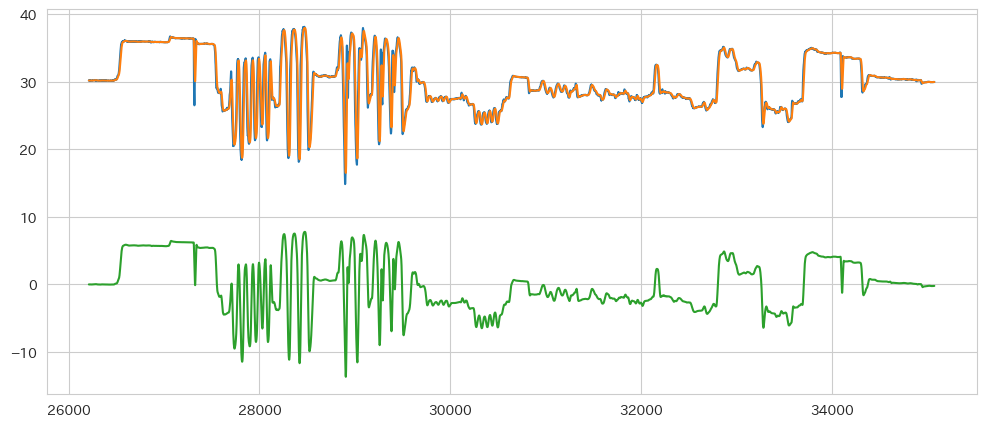

  Target: 接触 %_1          | R2: 0.6556 | MAE: 4.3396 | RMSE: 5.5382


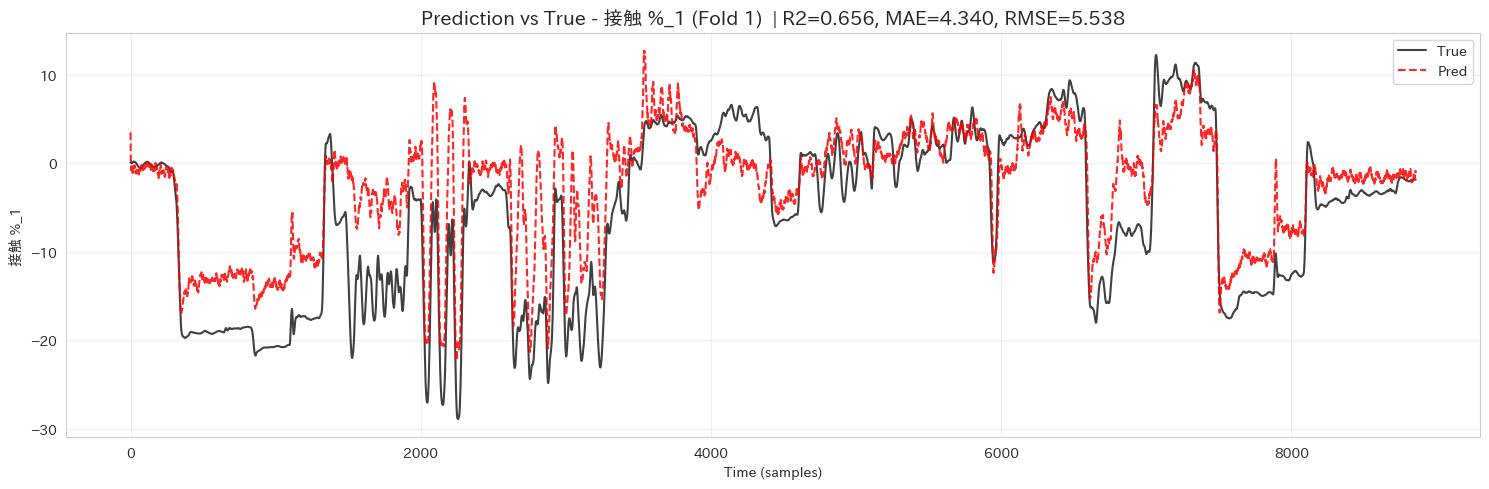

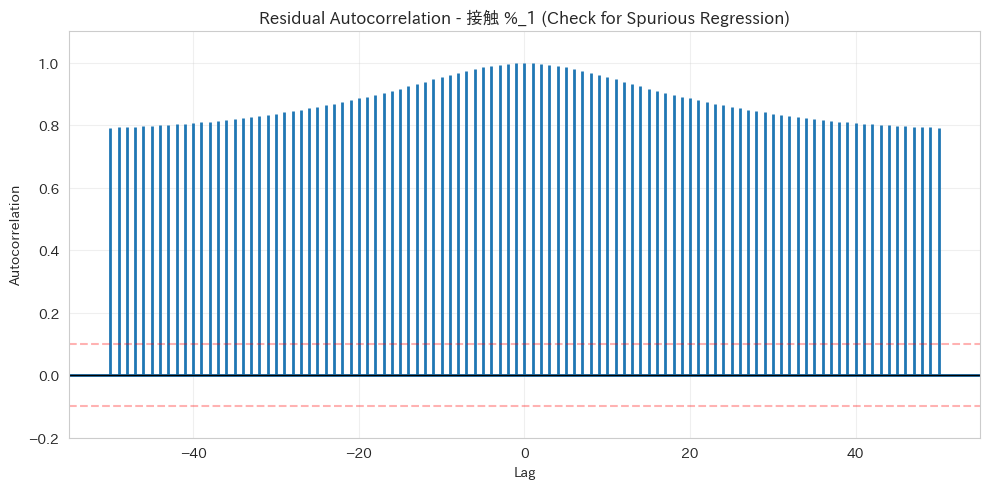

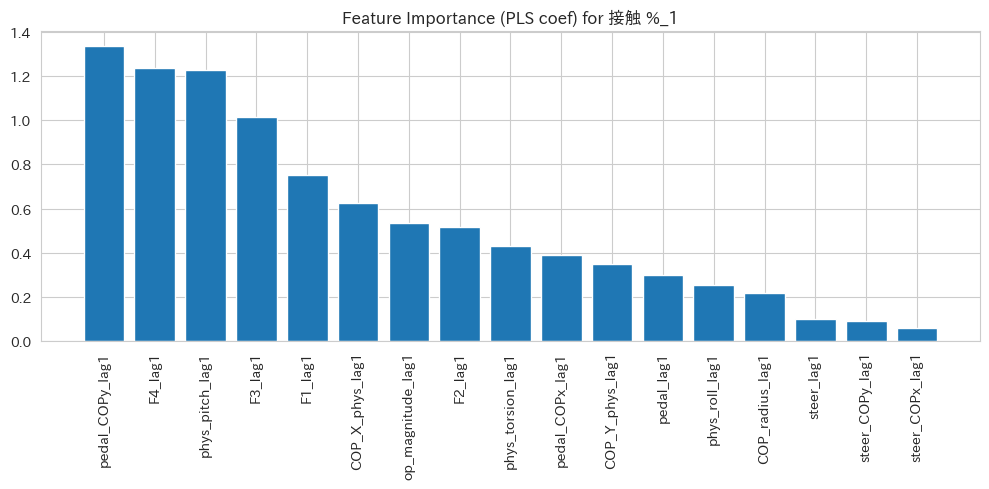

  Target: 荷重(N)_1         | R2: 0.8200 | MAE: 32.2151 | RMSE: 39.9184


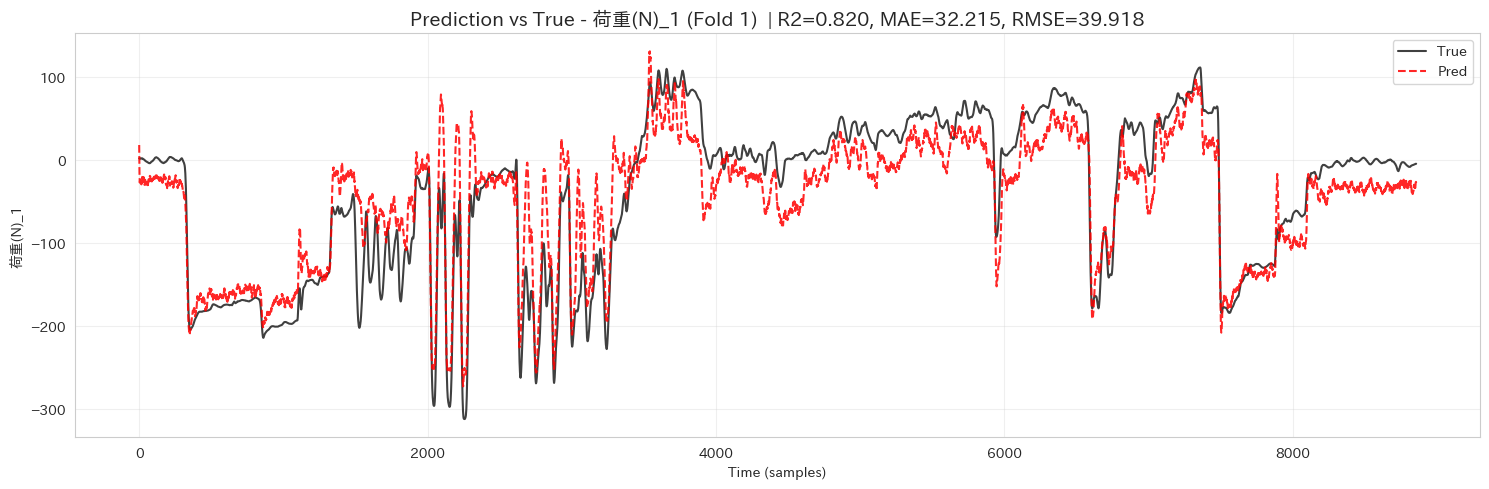

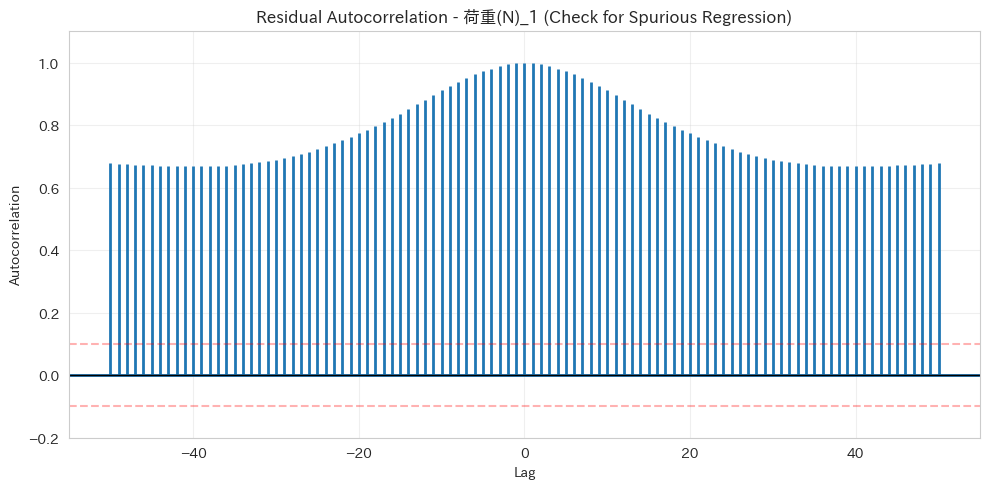

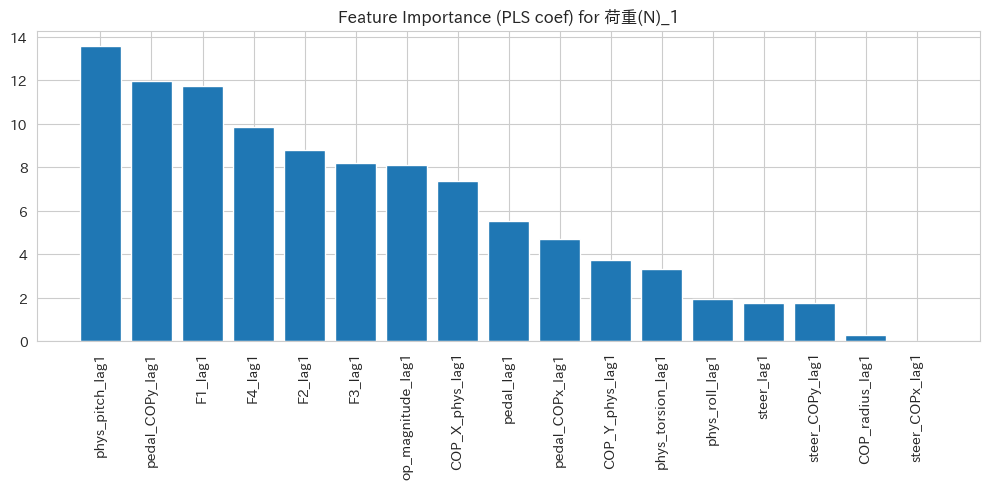

  Target: 圧力中心行_1         | R2: 0.4471 | MAE: 1.8220 | RMSE: 2.8462


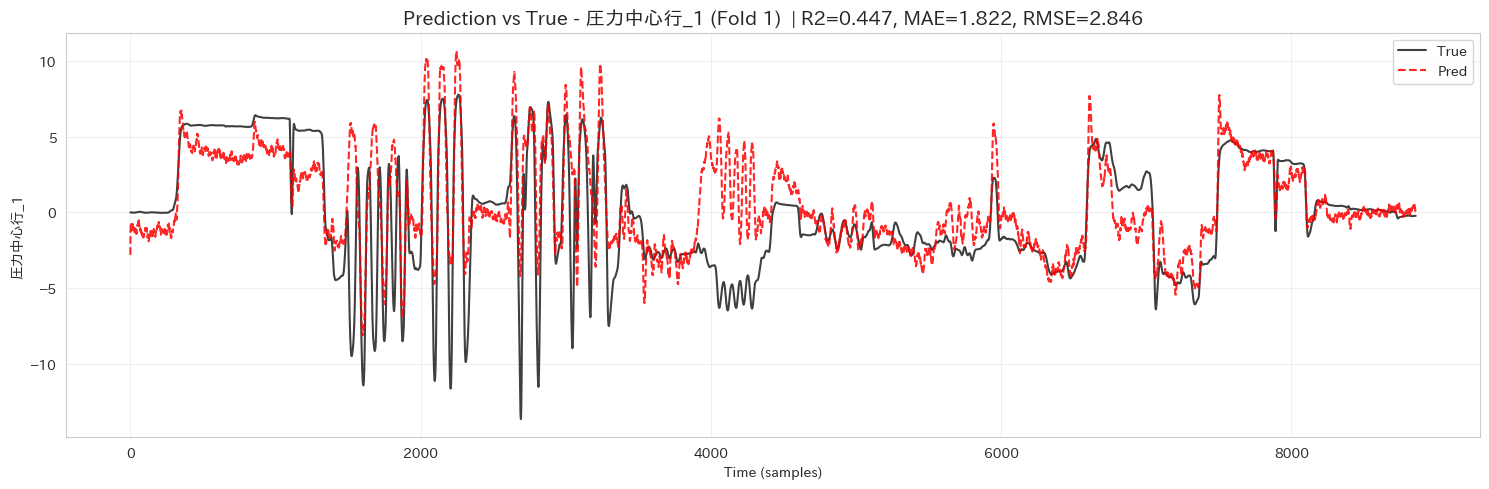

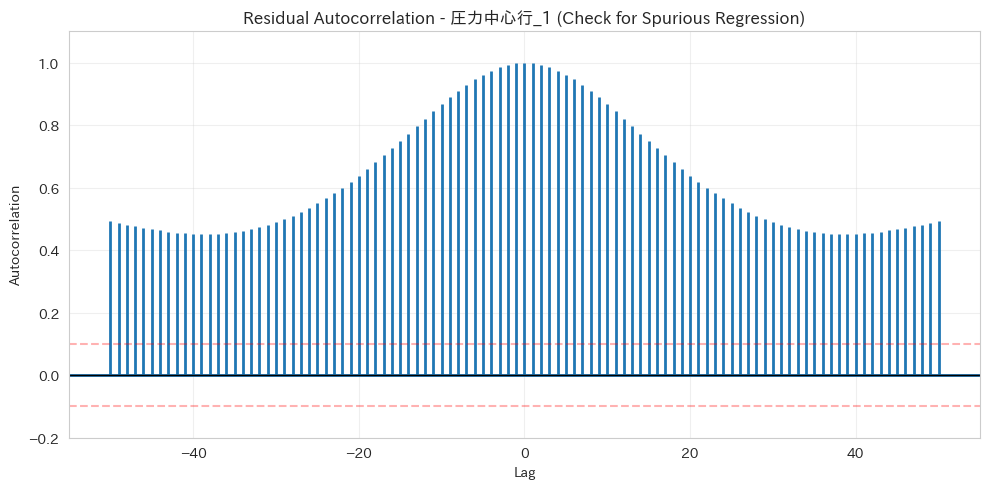

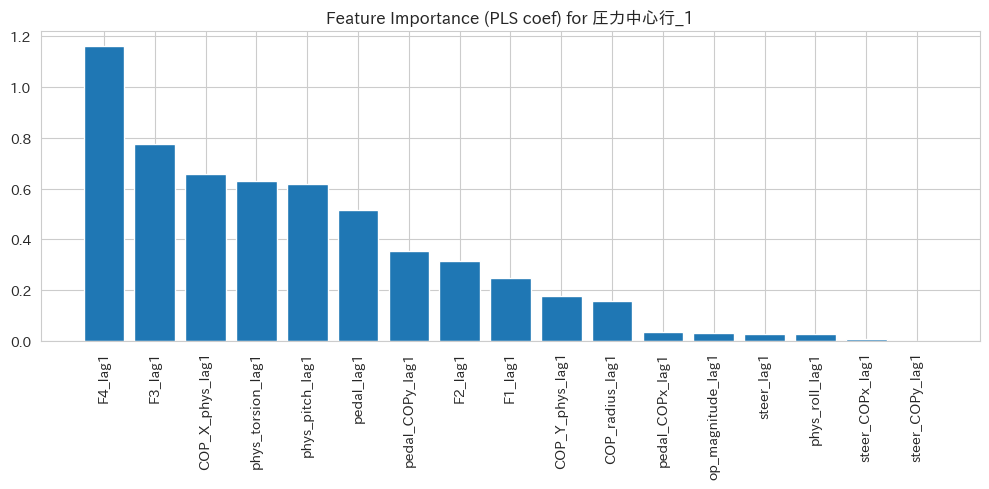

  Target: 圧力中心列_1         | R2: 0.8305 | MAE: 0.5629 | RMSE: 1.0114


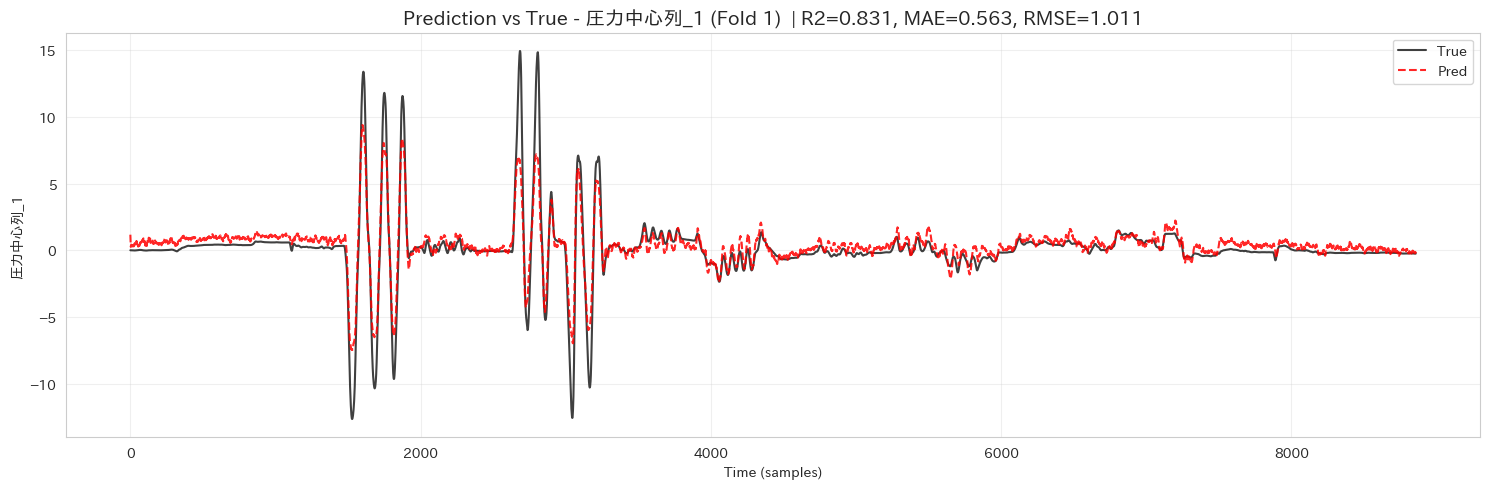

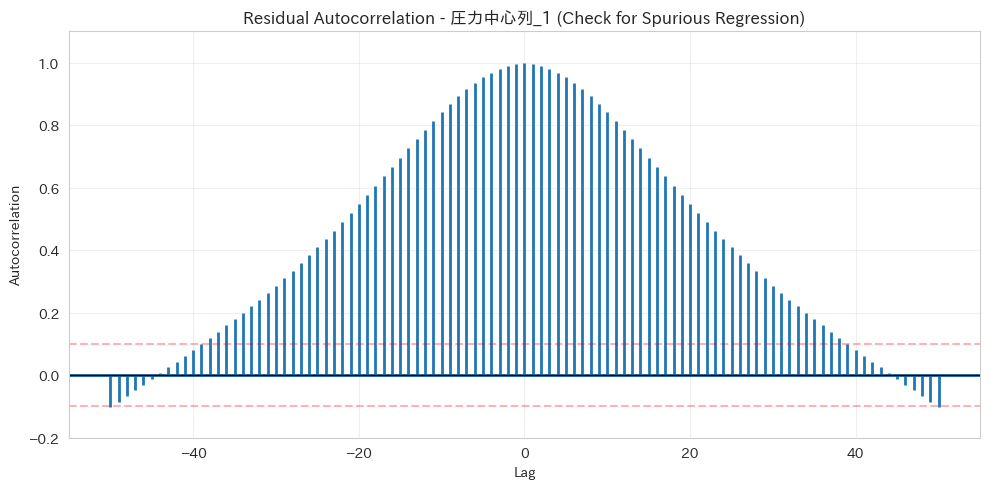

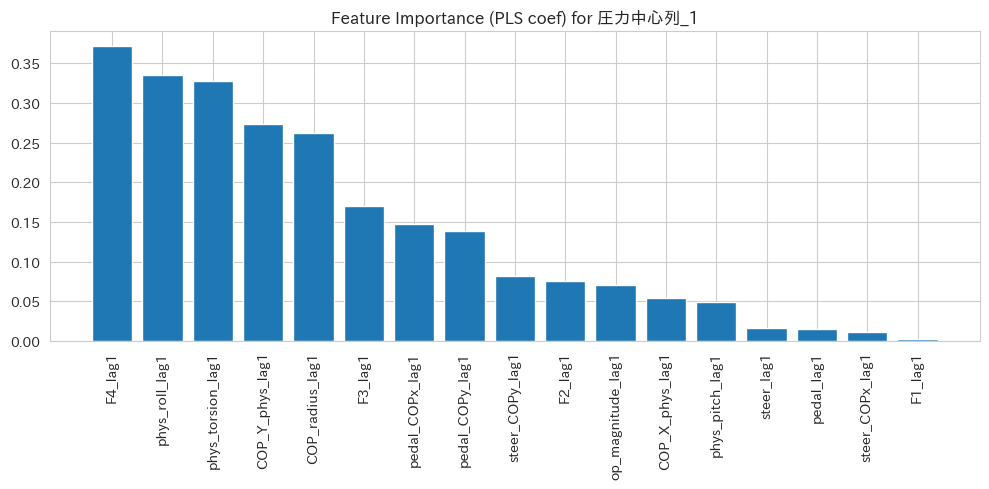

  Target: 平均圧力_2          | R2: 0.5542 | MAE: 0.0299 | RMSE: 0.0399


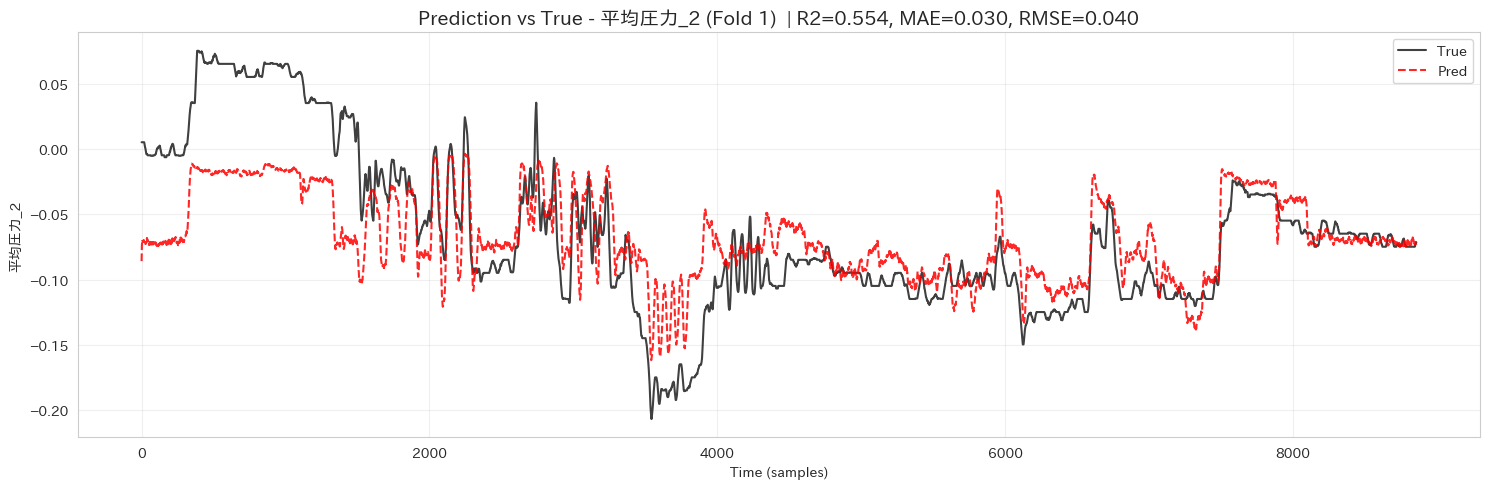

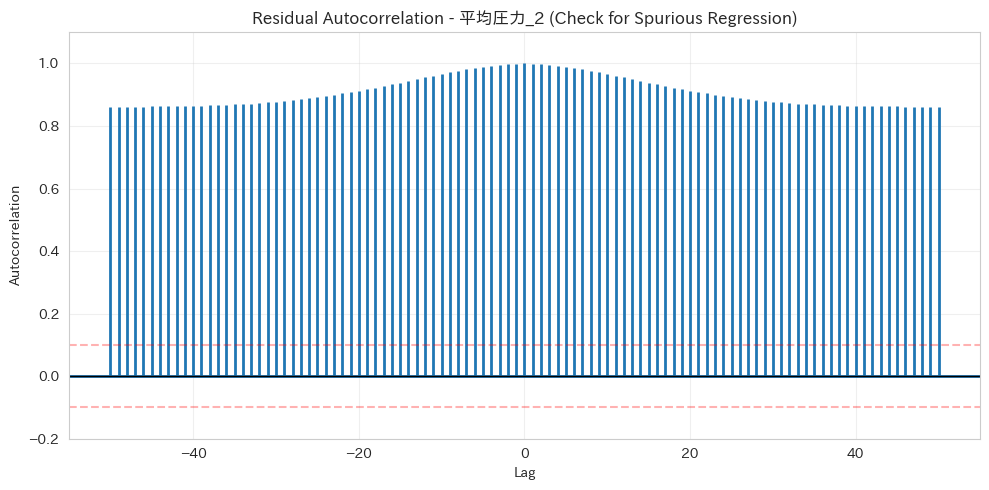

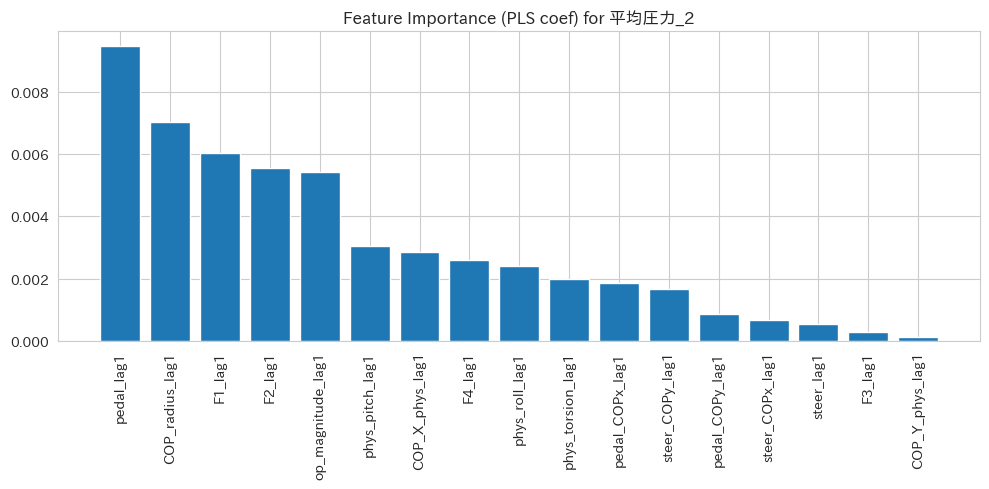

  Target: 荷重(N)_2         | R2: 0.1891 | MAE: 89.4128 | RMSE: 98.4757


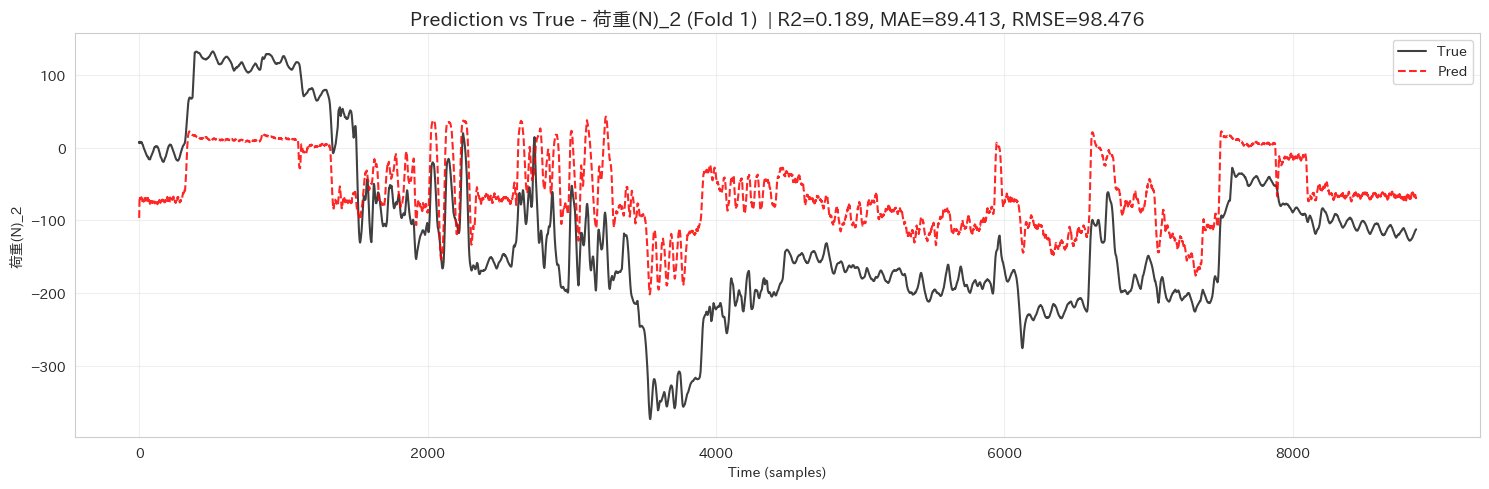

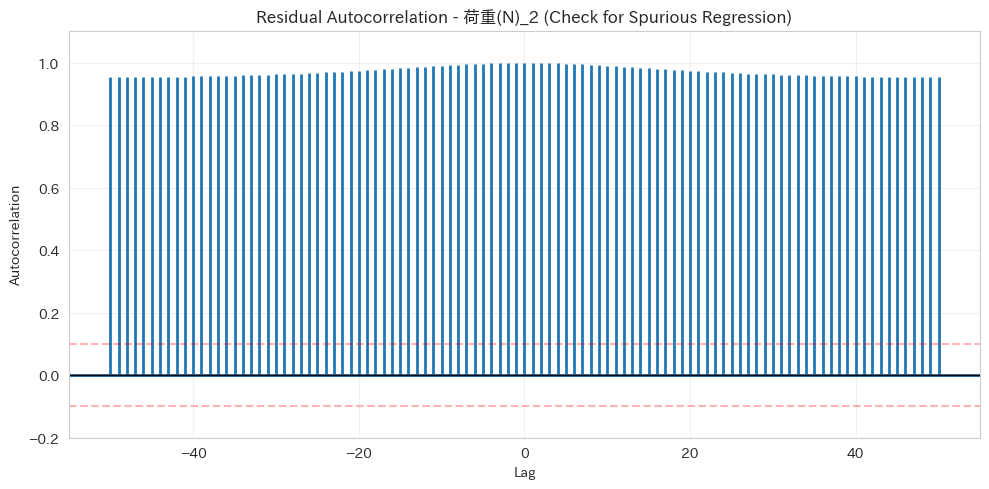

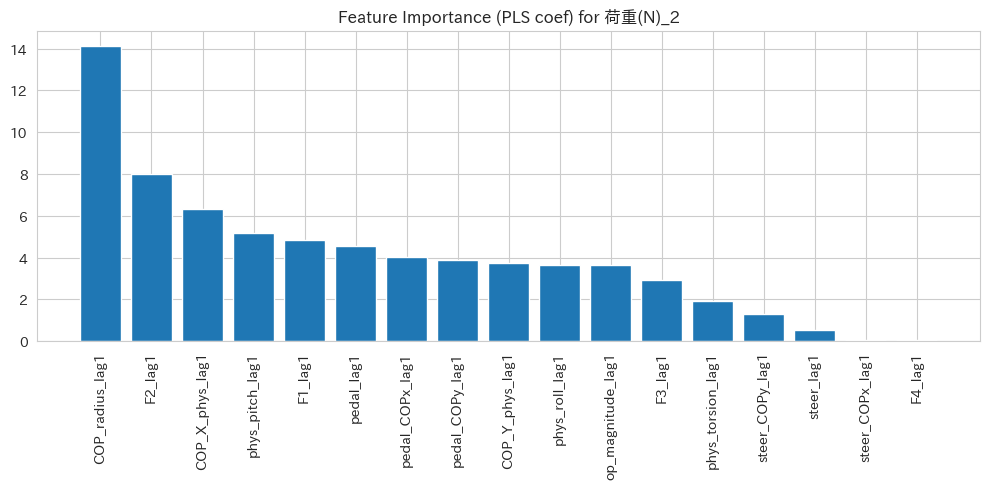

  Target: 圧力中心列_2         | R2: 0.8043 | MAE: 0.2563 | RMSE: 0.3639


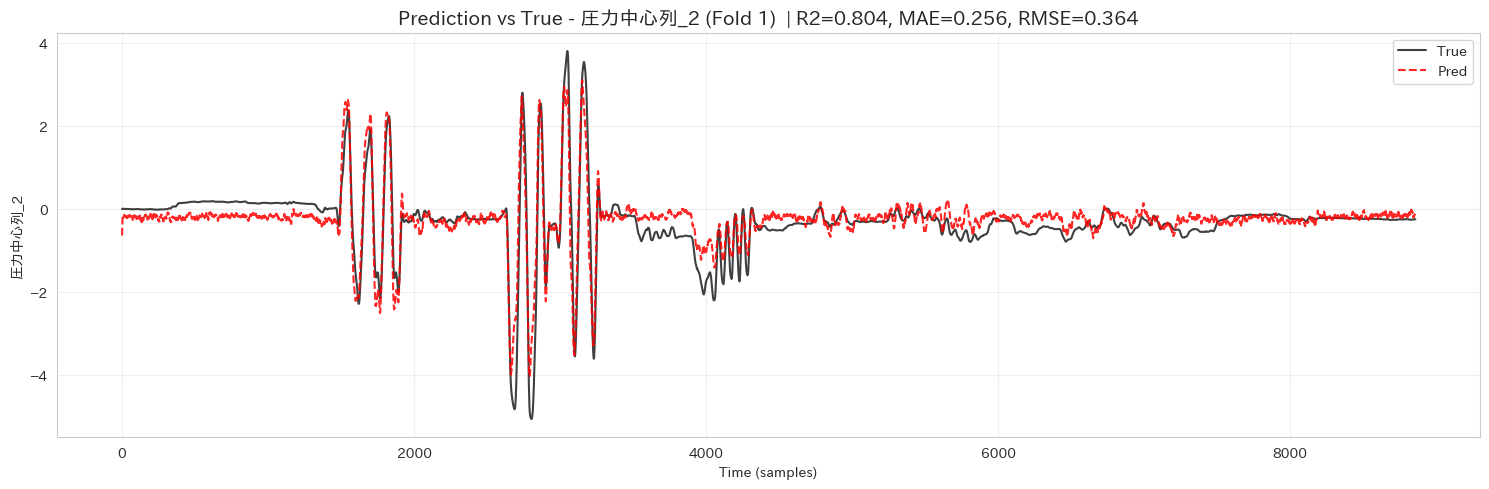

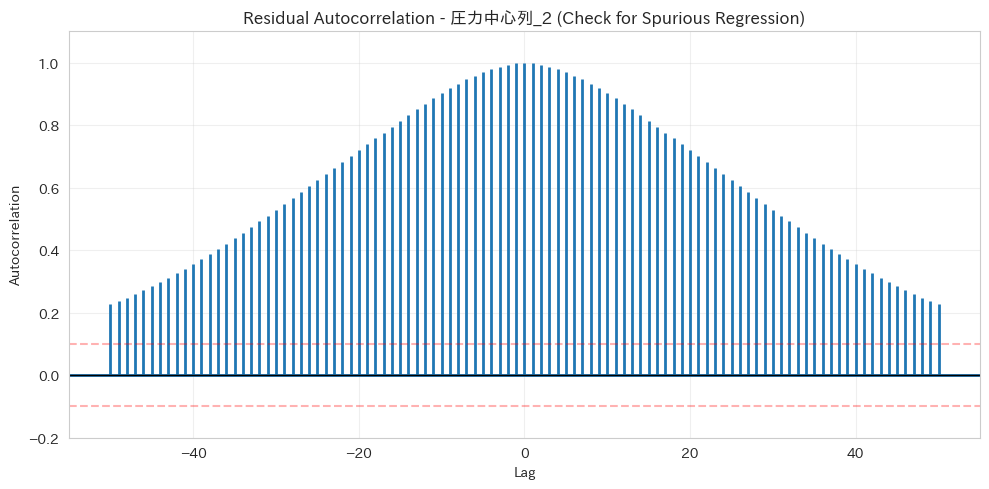

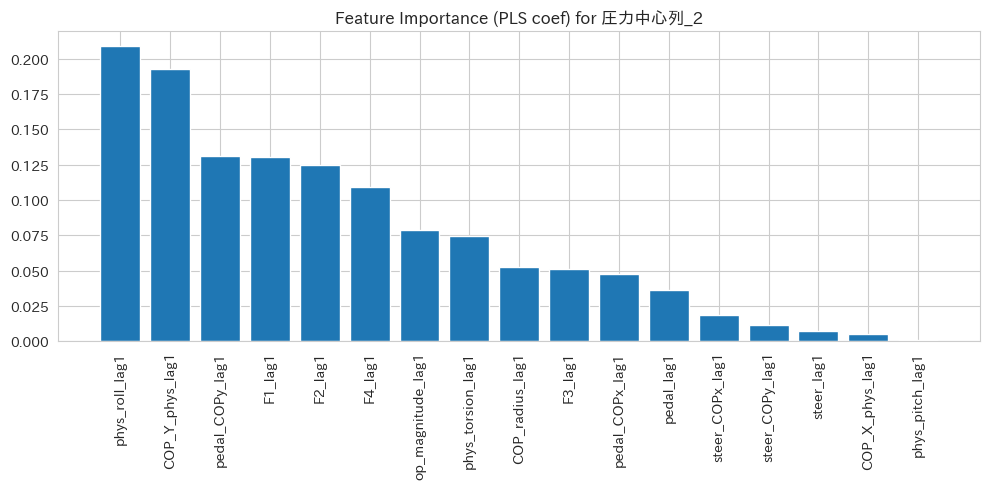


✅ Model A (Test Run) saved to 'model_a_test_run.pkl'
   Contents keys: ['接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_2', '荷重(N)_2', '圧力中心列_2']


In [54]:
def run_corrected_pipeline(X_raw, y_raw, scale_y=False, use_diff_target=True, holdout_subject_ids=None,n_components='auto',inner_cv_method='random',optimize_lags=True,my_optimal_lags=None):
    # ... (冒頭のprint文やIDチェックは変更なし) ...
    print("=" * 60)
    if holdout_subject_ids is not None:
        if isinstance(holdout_subject_ids, int): holdout_subject_ids = [holdout_subject_ids]
        print(f"🚀 改良版パイプライン: Hold-out Subject Mode (Test IDs: {holdout_subject_ids})")
    else:
        print("🚀 改良版パイプライン: TimeSeriesSplit Mode")
    
    # 0. 前提チェック
    if 'subject_id' not in X_raw.columns:
        X_raw = X_raw.assign(subject_id=1)

    # --- 分割ロジック ---
    if holdout_subject_ids is not None:
        mask_test = X_raw['subject_id'].isin(holdout_subject_ids)
        if mask_test.sum() == 0: raise ValueError(f"指定されたID {holdout_subject_ids} はデータ内に存在しません。")
        train_indices = np.where(~mask_test)[0]
        test_indices  = np.where(mask_test)[0]
        cv_splits = [(train_indices, test_indices)]
    else:
        tscv = TimeSeriesSplit(n_splits=3)
        cv_splits = tscv.split(X_raw)

    # プロセッサ初期化
    smoother = SubjectAwareSmoother(window=15)
    detrender = SubjectAwareDetrender(window=300)
    # ★変更点: Detrenderの代わりに初期値除去クラスをインスタンス化
    bias_subtractor = SubjectAwareInitialBiasSubtractor(n_samples=60)
    differencer = SubjectAwareDifferencer()
    
    all_scores = {col: [] for col in y_raw.columns}
    final_lags_history = {}
    
    # ★追加: 学習済みモデルを保存する辞書
    trained_models_collection = {} 

    for fold, (train_idx, test_idx) in enumerate(cv_splits):
        print(f"\n--- Fold {fold+1} ---")
        
        # ... (データ分割処理は変更なし) ...
        X_train_raw = X_raw.iloc[train_idx].copy()
        y_train_raw = y_raw.iloc[train_idx].copy()
        X_test_raw = X_raw.iloc[test_idx].copy()
        y_test_raw = y_raw.iloc[test_idx].copy()

        y_train_raw['subject_id'] = X_train_raw['subject_id']
        y_test_raw['subject_id'] = X_test_raw['subject_id']

        if holdout_subject_ids is not None:
            X_context_data = None
            y_context_data = None
        else:
            X_context_data = X_train_raw
            y_context_data = y_train_raw

        # ----------------------------------------
        # 2. Preprocessing Flow (変更なし)
        # ----------------------------------------
        if use_diff_target:
            y_train = differencer.transform(y_train_raw)
            y_test  = differencer.transform(y_test_raw, X_context=y_context_data)
        else:
            y_train = y_train_raw.copy()
            y_test = y_test_raw.copy()

        X_train = smoother.transform(X_train_raw)
        X_test  = smoother.transform(X_test_raw, X_context=X_context_data)
        y_train = smoother.transform(y_train)
        plt.plot(y_test['圧力中心行_1'])
        y_test  = smoother.transform(y_test, X_context=y_context_data)
        plt.plot(y_test['圧力中心行_1'])

        if 0:
            X_train = detrender.transform(X_train)
            X_test  = detrender.transform(X_test, X_context=X_context_data)
            y_train = detrender.transform(y_train)
            y_test  = detrender.transform(y_test, X_context=y_context_data)
        else:
            # Testデータも「そのセッションの開始」として初期値を引く場合
            X_train = bias_subtractor.transform(X_train)
            X_test  = bias_subtractor.transform(X_test) 
            y_train = bias_subtractor.transform(y_train)
            y_test  = bias_subtractor.transform(y_test)
        
        plt.plot(y_test['圧力中心行_1'])
        plt.show()

        # ------------------------------------------------
        # Step: ラグの最適化 (変更なし)
        # ------------------------------------------------
        if optimize_lags:
            print("🤖 Computing Robust Lags...")
            robust_model = RobustLagModel(lag_strategy='conservative')
            y_target_col = y_raw.columns[0] 
            base_lags = robust_model.compute_robust_lags(X_train, y_train[[y_target_col]])
            selector = AutoLagSelector(base_lags, search_range=[-10, -5, 0, 5, 10], cv_splits=3)
            selector.fit(X_train, y_train[[y_target_col]], groups=X_train['subject_id'])
            optimal_lags = selector.best_lags_
        else:
            optimal_lags = my_optimal_lags

        generator = CausalFeatureGenerator(optimal_lags)

        # ★Foldごとのモデル保存用辞書
        fold_models = {}

        # 3. Feature Generation Loop
        for y_col in [c for c in y_raw.columns if c != 'subject_id']:
            
            # ... (特徴量生成・ID復帰・DropNA・Standardizationまで変更なし) ...
            X_train_feats = generator.transform(X_train, y_col)
            X_test_feats = generator.transform(X_test, y_col)
            
            X_train_feats['subject_id'] = X_train['subject_id'].values
            X_test_feats['subject_id'] = X_test['subject_id'].values
            
            y_train_target = y_train[[y_col, 'subject_id']]
            y_test_target = y_test[[y_col, 'subject_id']]

            common_idx_train = X_train_feats.dropna().index.intersection(y_train_target.dropna().index)
            X_train_clean = X_train_feats.loc[common_idx_train]
            y_train_clean = y_train_target.loc[common_idx_train]
            
            common_idx_test = X_test_feats.dropna().index.intersection(y_test_target.dropna().index)
            X_test_clean = X_test_feats.loc[common_idx_test]
            y_test_clean = y_test_target.loc[common_idx_test]

            if len(X_train_clean) < 100: 
                print(f"Skipping {y_col}: Not enough training data.")
                continue

            scaler_x = SubjectAwareStandardizer()
            scaler_x.fit(X_train_clean)
            
            X_train_final = scaler_x.transform(X_train_clean).drop(columns=['subject_id'], errors='ignore')
            X_test_final  = scaler_x.transform(X_test_clean).drop(columns=['subject_id'], errors='ignore')

            scaler_y = None
            if scale_y:
                scaler_y = SubjectAwareStandardizer()
                scaler_y.fit(y_train_clean)
                y_train_final = scaler_y.transform(y_train_clean).drop(columns=['subject_id'], errors='ignore')
                y_test_final  = scaler_y.transform(y_test_clean).drop(columns=['subject_id'], errors='ignore')
            else:
                y_train_final = y_train_clean.drop(columns=['subject_id'], errors='ignore')
                y_test_final  = y_test_clean.drop(columns=['subject_id'], errors='ignore')

            # ---------------------------------------------------------
            # モデル学習部分は変更なし
            # ---------------------------------------------------------
            train_groups = X_train_clean['subject_id'].values
            if n_components == 'auto':
                model = AutoTunedPLSModel(max_components=30, cv_splits=5, cv_method=inner_cv_method)
                model.fit(X_train_final, y_train_final, groups=train_groups)
                best_n = model.best_n_components_
                print(f"  [{y_col}] Auto-tuned Best n_components: {best_n}")
            else:
                model = SimplePLSModel(n_components=int(n_components))
                model.fit(X_train_final, y_train_final)

            # ---------------------------------------------------------
            # ▼▼▼ 推論・評価・プロット (ここを修正) ▼▼▼
            # ---------------------------------------------------------
            y_pred_raw = model.predict(X_test_final)
            y_pred = pd.Series(y_pred_raw.flatten(), index=y_test_final.index)

            # 逆標準化 (scale_y=Trueの場合)
            if scale_y and scaler_y is not None:
                # YのScalerを使って元のスケールに戻す
                y_pred_real_vals = scaler_y.inverse_transform(y_pred.values.reshape(-1, 1)).flatten()
                y_pred_real = pd.Series(y_pred_real_vals, index=y_test_final.index)
            else:
                y_pred_real = y_pred

            # 評価指標の計算 (学習ターゲットに対する精度)
            r2 = r2_score(y_test_final, y_pred) # Scaled同士でもR2は同じだが、確認用
            mae = mean_absolute_error(y_test_final, y_pred)
            mse = mean_squared_error(y_test_final, y_pred)
            rmse = np.sqrt(mse)
            all_scores[y_col].append(r2)

            # ログ出力
            print(f"  Target: {y_col:<15} | R2: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

            # =========================================================
            # 分岐処理: 差分あり vs なし
            # =========================================================
            if use_diff_target:
                # --- A. 差分学習の場合 (復元処理が必要) ---
                
                # 1. 累積和で形状を復元 (Zero-based Integration)
                y_pred_restored_values = np.cumsum(y_pred_real.values)

                # 2. 正解データも比較用に処理
                # y_test_raw (Rawデータ) から該当期間を取得し、開始点を0に合わせる
                if y_col in y_test_raw.columns:
                    y_true_raw_aligned = y_test_raw.loc[y_test_final.index, y_col]
                    true_raw_values = y_true_raw_aligned.values
                    
                    if len(true_raw_values) > 0:
                        start_bias = true_raw_values[0]
                        y_true_restored_values = true_raw_values - start_bias
                        
                        y_pred_restored = pd.Series(y_pred_restored_values, index=y_test_final.index)
                        y_true_restored = pd.Series(y_true_restored_values, index=y_test_final.index)
                        
                        # 形状R2
                        r2_restored = r2_score(y_true_restored, y_pred_restored)
                        print(f"  Target: {y_col:<15} | Diff R2: {r2:.4f} | Shape R2: {r2_restored:.4f}")
                    else:
                        y_pred_restored, y_true_restored, r2_restored = None, None, None
                else:
                    y_pred_restored, y_true_restored, r2_restored = None, None, None

                # 3. プロット (Dual)
                is_last_fold = (fold == len(list(cv_splits)) - 1) if not isinstance(cv_splits, list) else True
                if holdout_subject_ids is not None or is_last_fold:
                    plot_dual_waveform(
                        y_true_diff=y_test_final, 
                        y_pred_diff=y_pred, # model output (scaled or raw diff)
                        y_true_raw=y_true_restored, 
                        y_pred_restored=y_pred_restored,
                        y_col=y_col, 
                        fold_id=f"Fold {fold+1}",
                        score_diff=r2,
                        score_restored=r2_restored
                    )

            else:
                # --- B. 差分なし (通常学習) の場合 ---
                
                # そのままプロット
                is_last_fold = (fold == len(list(cv_splits)) - 1) if not isinstance(cv_splits, list) else True
                if holdout_subject_ids is not None or is_last_fold:
                    plot_simple_waveform(
                        y_true=y_test_final, # 前処理(Smooth/Detrend)済みの正解
                        y_pred=y_pred,       # モデル予測値
                        y_col=y_col,
                        fold_id=f"Fold {fold+1}",
                        score=r2,
                        mae=mae,
                        rmse=rmse
                    )
            
            # --- 共通: 残差相関チェックなど ---
            if holdout_subject_ids is not None or is_last_fold:
                 plot_residual_acorrelation(y_test_final, y_pred, y_col)
                 # 特徴量重要度など...
                 if hasattr(model, 'model'): inner_model = model.model
                 else: inner_model = model.model
                 plot_feature_importance(inner_model, X_train_final.columns, y_col)

            num_val_samples = 3000
            # モデル保存
            fold_models[y_col] = {
                'model': model,
                'scaler_x': scaler_x,
                'scaler_y': scaler_y,
                'lags': optimal_lags,
                'test_sample_row': X_test_clean.iloc[:num_val_samples]
            }

            if y_col not in final_lags_history:
                final_lags_history[y_col] = []
            final_lags_history[y_col].append(optimal_lags)
        
        trained_models_collection = fold_models

    return all_scores, final_lags_history, trained_models_collection


#####3
# 実行
#######

import joblib

# データの準備 (既存コードのまま)
mock_sensor_cols = ['F1', 'F2', 'F3', 'F4', 
                    # 'FX_filtered', 'FY_filtered',
                    'COP_X_phys','COP_Y_phys','pedal','steer',#'interact_steer_pedal',
       'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius', #'COP_angle', 
       'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy','subject_id']

# target_features_A = ['圧力中心列_2', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1','ピーク圧力_1','接触 %_1','接触 %_2']
# target_features_A = ['標準偏差_1', '標準偏差_2',
#     'ピーク圧力_1', '接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1', '平均圧力_1',
#     '平均圧力_2', 'ピーク圧力_2', '接触 %_2', '荷重(N)_2', '圧力中心行_2', '圧力中心列_2']

# モデルAで作りやすい(第一候補)
target_features_A = ['接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1',
    '平均圧力_2','荷重(N)_2', '圧力中心列_2']

available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]
df_raw = df_all[X_cols + Y_cols].dropna()
X_raw = df_raw[X_cols]
y_raw = df_raw[Y_cols]

# ==========================================
# パイプライン実行
# ==========================================
# ★戻り値を3つ受け取るように変更
scores, lags_history, trained_models_a = run_corrected_pipeline(
    X_raw, 
    y_raw, 
    scale_y=False,
    use_diff_target=False, # 差分学習
    holdout_subject_ids=[7], # テスト用被験者
    n_components=4, 
    inner_cv_method='group',
    optimize_lags=False,
    my_optimal_lags=my_optimal_lags, # my_optimal_lags=None
)


# ==========================================
# モデルAの保存
# ==========================================
# 推論に必要な情報（モデル、前処理設定、ラグなど）をまとめる
artifacts_a = {
    'models': trained_models_a, # ターゲットごとの{model, scaler, lags}
    'input_columns': X_cols,    # 入力特徴量名
    'preprocessors': {          # 共通前処理パラメータ
        'smooth_window': 15,# 差分学習
        'detrend_window': 3 # 300
    }
}

save_path_a = 'model_a_test_run.pkl'
joblib.dump(artifacts_a, save_path_a)

print("\n" + "="*60)
print(f"✅ Model A (Test Run) saved to '{save_path_a}'")
print(f"   Contents keys: {list(trained_models_a.keys())}")
print("="*60)


In [24]:
df_all.columns

Index(['time', 'F1', 'F2', 'F3', 'F4', 'steer', 'pedal', 'FX_filtered',
       'FY_filtered', '平均圧力_1', '最低圧力_1', 'ピーク圧力_1', '接触域 (cm²)_1',
       '選択領域(cm²)_1', '接触 %_1', '荷重(N)_1', '標準偏差_1', '平均_1', '圧力中心行_1',
       '圧力中心列_1', '平均圧力_2', '最低圧力_2', 'ピーク圧力_2', '接触域 (cm²)_2', '選択領域(cm²)_2',
       '接触 %_2', '荷重(N)_2', '標準偏差_2', '平均_2', '圧力中心行_2', '圧力中心列_2',
       'subject_id', 'W', 'COP_X_phys', 'COP_Y_phys', 'phys_pitch',
       'phys_roll', 'phys_torsion', 'COP_radius', 'COP_angle', 'op_magnitude',
       'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy',
       'interact_steer_pedal'],
      dtype='object')

(0.0, 3000.0)

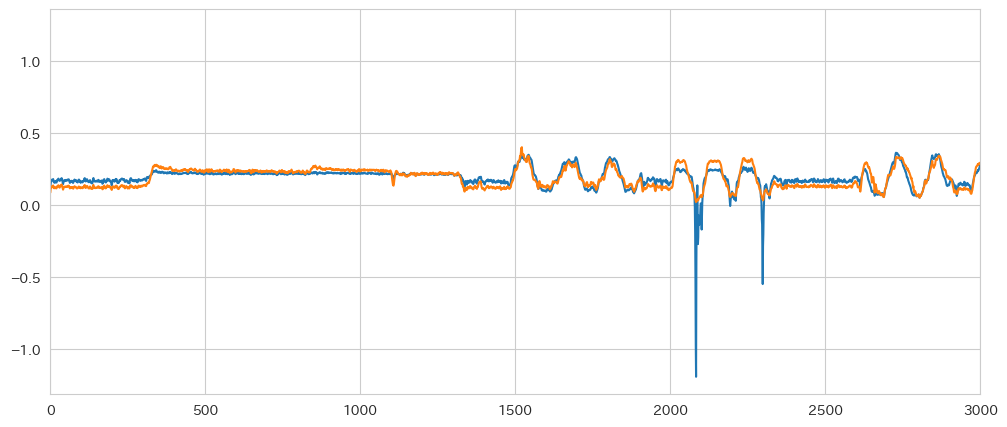

In [41]:
mock_sensor_cols = ['F1', 'F2', 'F3', 'F4', 
                    'FX_filtered', 'FY_filtered',
                    'COP_X_phys','COP_Y_phys','pedal','steer',#'interact_steer_pedal',
       'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius', #'COP_angle', 
       'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy','subject_id']

# モデルAで作りやすい(第一候補)
target_features_A = ['接触 %_1', '荷重(N)_1', '圧力中心行_1', '圧力中心列_1',
    '平均圧力_2','荷重(N)_2', '圧力中心列_2']

available_cols = df_all.columns.tolist()
X_cols = [c for c in mock_sensor_cols if c in available_cols]
Y_cols = [c for c in target_features_A if c in available_cols]
df_tmp = df_all[X_cols + Y_cols].dropna()
target = df_tmp.query('subject_id == 7').reset_index(drop=True)
target.to_csv("model_a_test_df_raw.csv", header=False, index=False, encoding='utf-8')

plt.plot(target.FX_filtered)
plt.plot(target.FY_filtered)
# plt.plot(target.F1)
plt.xlim(0,3000)

# plt.plot(target['圧力中心行_1'])


In [ ]:
# =========================================================
# 🚀 Model A (PLS) LabVIEW用係数出力 & 検証データ作成 (Multi-Frame Version)
# =========================================================
print("\n" + "="*60)
print("🚀 Model A (PLS) LabVIEW Coefficients & Multi-Frame Validation Data")
print("="*60)

labview_weights_dict = {}
labview_biases_dict = {}
feature_order_info = []

# 検証データを保持する変数
validation_input_matrix = None # (N_samples, N_features)
validation_predictions = {}    # target -> (N_samples,) array

# --- 内部関数 (変更なし) ---
def find_attribute(obj, candidates):
    for name in candidates:
        if hasattr(obj, name):
            return getattr(obj, name)
    return None

def get_standard_scaler_params(scaler_obj):
    mu = find_attribute(scaler_obj, ['mean_', 'mean', 'center_', 'means_'])
    sigma = find_attribute(scaler_obj, ['scale_', 'scale', 'std_', 'stds_'])
    
    if mu is None and hasattr(scaler_obj, 'scaler'):
        inner = scaler_obj.scaler
        mu = find_attribute(inner, ['mean_', 'mean'])
        sigma = find_attribute(inner, ['scale_', 'scale'])
    return mu, sigma

# =========================================================
# メインループ
# =========================================================
for target_col, artifact in trained_models_a.items():
    print(f"Processing Target: {target_col} ...", end=" ")
    
    wrapper_model = artifact['model']
    scaler_x = artifact['scaler_x']
    
    # A. モデル本体取得
    if hasattr(wrapper_model, 'model'):
        pls_model = wrapper_model.model
    else:
        pls_model = wrapper_model
        
    # B. 係数取得
    if not hasattr(pls_model, 'coef_'):
        print(f"[Skip] coef_ なし")
        continue
    w_pls = pls_model.coef_ 
    if w_pls.ndim == 1: w_pls = w_pls.reshape(-1, 1)

    # C. 特徴量名取得
    feature_names = None
    if hasattr(scaler_x, 'feature_names_in_'):
        feature_names = list(scaler_x.feature_names_in_)
    elif hasattr(pls_model, 'feature_names_in_'):
        feature_names = list(pls_model.feature_names_in_)
    
    # D. Scalerパラメータ取得
    mu_x = None
    sigma_x = None
    if hasattr(scaler_x, 'global_stats') and isinstance(scaler_x.global_stats, dict):
        gs = scaler_x.global_stats
        if feature_names is None: feature_names = list(gs.keys())
        try:
            mu_list, sigma_list = [], []
            for fname in feature_names:
                val = gs[fname]
                mu_list.append(val[0])
                sigma_list.append(val[1])
            mu_x = np.array(mu_list).reshape(-1, 1)
            sigma_x = np.array(sigma_list).reshape(-1, 1)
        except: mu_x = None

    if mu_x is None:
        mu_x, sigma_x = get_standard_scaler_params(scaler_x)

    if mu_x is None or sigma_x is None:
        print(f" [Error] Scalerパラメータ不明")
        continue

    # 次元不一致の修正
    if w_pls.shape[0] != mu_x.shape[0]:
        if w_pls.ndim == 2 and w_pls.shape[1] == mu_x.shape[0]:
            w_pls = w_pls.T 
        else:
            print(f" [Error] 次元不一致 W:{w_pls.shape} vs S:{mu_x.shape}")
            continue

    # E. 切片取得
    if hasattr(pls_model, 'intercept_'):
        b_pls = pls_model.intercept_
    elif hasattr(pls_model, '_y_mean') and hasattr(pls_model, '_x_mean'):
        b_pls = pls_model._y_mean - np.dot(pls_model._x_mean, pls_model.coef_)
    else:
        b_pls = 0.0

    # F. 係数合成 (Affine Transformation)
    try:
        w_effective = w_pls / sigma_x
        bias_correction = np.dot(mu_x.T, w_effective)
        b_effective = b_pls - bias_correction
        
        labview_weights_dict[target_col] = w_effective.flatten()
        labview_biases_dict[target_col] = b_effective.flatten()[0]
        
        feature_order_info.append({
            'target': target_col,
            'feature_names': feature_names
        })
        
        # =========================================================
        # ★検証用入力データの取得 (複数行対応)
        # =========================================================
        if validation_input_matrix is None:
            if 'test_sample_row' in artifact:
                sample_df = artifact['test_sample_row'] # DataFrame (N_samples, N_features)
                
                # 特徴量順序揃え
                if feature_names:
                    try:
                        sample_sorted = sample_df[feature_names]
                        validation_input_matrix = sample_sorted.values # (N, F)
                        print(f"(Input: {validation_input_matrix.shape} samples)", end=" ")
                    except KeyError as e:
                        print(f"\n[Warning] 特徴量不一致: {e}")
                        # フォールバック: 平均値1行分だけ
                        validation_input_matrix = mu_x.T 
                else:
                    validation_input_matrix = sample_df.values
            else:
                print(f"\n[Warning] 'test_sample_row' なし。平均値代用。", end=" ")
                validation_input_matrix = mu_x.T

        # 検証: 期待値の計算 (Y = XW + B)
        # X: (N, F), W: (F, 1), B: scalar -> Y: (N, 1)
        pred_vals = np.dot(validation_input_matrix, w_effective) + b_effective
        
        # 1次元配列として保存
        validation_predictions[target_col] = pred_vals.flatten()
        
        print(f"✅ OK")
        
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f" [Error] {e}")
        continue

# =========================================================
# CSV書き出し
# =========================================================
print("-" * 60)
if not feature_order_info:
    print("❌ 出力対象なし")
else:
    first_feats = feature_order_info[0]['feature_names']
    is_common = all(info['feature_names'] == first_feats for info in feature_order_info)

    if is_common:
        print("✅ 特徴量構成一致。統合ファイルを出力します。")
        
        # 1. 重み (Weights)
        df_weights = pd.DataFrame(index=first_feats)
        df_biases = pd.DataFrame(index=['Bias'])
        
        for target in labview_weights_dict.keys():
            df_weights[target] = labview_weights_dict[target]
            df_biases[target] = labview_biases_dict[target]
            
        df_weights.to_csv("model_a_weights.csv", header=False, index=False, encoding='utf-8')
        df_biases.to_csv("model_a_biases.csv", header=False, index=False, encoding='utf-8')
        
        # 2. 入力順序 (Input Order)
        pd.DataFrame(first_feats, columns=['Feature_Order']).to_csv("model_a_input_order.csv", index=False, encoding='utf-8-sig')
        
        # 3. 検証用入力 (Test Input) -> (N_samples, N_features)
        # LabVIEW側ではこれを1行ずつ読み込むか、まとめて読み込んでForループで回す
        pd.DataFrame(validation_input_matrix).to_csv("model_a_test_input.csv", header=False, index=False, encoding='utf-8')
        
        # 4. 検証用期待値 (Test Output) -> (N_samples, N_targets)
        # 列順序を weights の列順序と合わせる
        target_order = df_weights.columns.tolist()
        df_pred_output = pd.DataFrame()
        for target in target_order:
            df_pred_output[target] = validation_predictions[target]
            
        df_pred_output.to_csv("model_a_test_output_expected.csv", header=False, index=False, encoding='utf-8')
        
        print("\n[保存完了]")
        print(" 1. model_a_weights.csv              : 重み行列 (Feature x Target)")
        print(" 2. model_a_biases.csv               : バイアス (1 x Target)")
        print(" 3. model_a_input_order.csv          : 入力順序")
        print(f" 4. model_a_test_input.csv           : 検証入力 ({validation_input_matrix.shape[0]} samples)")
        print(f" 5. model_a_test_output_expected.csv : 検証期待値 ({df_pred_output.shape[0]} samples)")

    else:
        print("⚠️ 特徴量構成不一致のため、統合出力できません。")


🚀 Model A (PLS) LabVIEW Coefficients & Multi-Frame Validation Data
Processing Target: 接触 %_1 ... (Input: (3000, 17) samples) ✅ OK
Processing Target: 荷重(N)_1 ... ✅ OK
Processing Target: 圧力中心行_1 ... ✅ OK
Processing Target: 圧力中心列_1 ... ✅ OK
Processing Target: 平均圧力_2 ... ✅ OK
Processing Target: 荷重(N)_2 ... ✅ OK
Processing Target: 圧力中心列_2 ... ✅ OK
------------------------------------------------------------
✅ 特徴量構成一致。統合ファイルを出力します。

[保存完了]
 1. model_a_weights.csv              : 重み行列 (Feature x Target)
 2. model_a_biases.csv               : バイアス (1 x Target)
 3. model_a_input_order.csv          : 入力順序
 4. model_a_test_input.csv           : 検証入力 (3000 samples)
 5. model_a_test_output_expected.csv : 検証期待値 (3000 samples)


In [ ]:
# # =========================================================
# # 前提チェック
# # =========================================================
# if 'trained_models_a' not in locals():
#     raise ValueError("変数 'trained_models_a' が見つかりません。パイプラインを実行した後にこのコードを走らせてください。")

# print("\n" + "="*60)
# print("🚀 Model A (PLS) LabVIEW用係数出力 & 検証データ作成 (Simple Version)")
# print("="*60)

# labview_weights_dict = {}
# labview_biases_dict = {}
# feature_order_info = []

# # 検証データを保持する変数
# validation_input_vector = None # LabVIEWに入力する1次元配列
# validation_predictions = {}    # ターゲットごとの期待値

# # --- 内部関数 ---
# def find_attribute(obj, candidates):
#     for name in candidates:
#         if hasattr(obj, name):
#             return getattr(obj, name)
#     return None

# def get_standard_scaler_params(scaler_obj):
#     mu = find_attribute(scaler_obj, ['mean_', 'mean', 'center_', 'means_'])
#     sigma = find_attribute(scaler_obj, ['scale_', 'scale', 'std_', 'stds_'])
    
#     if mu is None and hasattr(scaler_obj, 'scaler'):
#         inner = scaler_obj.scaler
#         mu = find_attribute(inner, ['mean_', 'mean'])
#         sigma = find_attribute(inner, ['scale_', 'scale'])
#     return mu, sigma

# # =========================================================
# # メインループ
# # =========================================================
# for target_col, artifact in trained_models_a.items():
#     print(f"Processing Target: {target_col} ...", end=" ")
    
#     wrapper_model = artifact['model']
#     scaler_x = artifact['scaler_x']
    
#     # A. モデル本体取得
#     if hasattr(wrapper_model, 'model'):
#         pls_model = wrapper_model.model
#     else:
#         pls_model = wrapper_model
        
#     # B. 係数取得
#     if not hasattr(pls_model, 'coef_'):
#         print(f"[Skip] coef_ なし")
#         continue
#     w_pls = pls_model.coef_ 
#     if w_pls.ndim == 1: w_pls = w_pls.reshape(-1, 1)

#     # C. 特徴量名取得
#     feature_names = None
#     if hasattr(scaler_x, 'feature_names_in_'):
#         feature_names = list(scaler_x.feature_names_in_)
#     elif hasattr(pls_model, 'feature_names_in_'):
#         feature_names = list(pls_model.feature_names_in_)
    
#     # D. Scalerパラメータ取得 (SubjectAwareStandardizer対応)
#     mu_x = None
#     sigma_x = None
#     if hasattr(scaler_x, 'global_stats') and isinstance(scaler_x.global_stats, dict):
#         gs = scaler_x.global_stats
#         if feature_names is None: feature_names = list(gs.keys())
#         try:
#             mu_list, sigma_list = [], []
#             for fname in feature_names:
#                 val = gs[fname]
#                 mu_list.append(val[0])
#                 sigma_list.append(val[1])
#             mu_x = np.array(mu_list).reshape(-1, 1)
#             sigma_x = np.array(sigma_list).reshape(-1, 1)
#         except: mu_x = None

#     if mu_x is None:
#         mu_x, sigma_x = get_standard_scaler_params(scaler_x)

#     if mu_x is None or sigma_x is None:
#         print(f" [Error] Scalerパラメータ不明")
#         continue

#     # 次元不一致の自動修正 (転置)
#     if w_pls.shape[0] != mu_x.shape[0]:
#         if w_pls.ndim == 2 and w_pls.shape[1] == mu_x.shape[0]:
#             w_pls = w_pls.T # (1, 195) -> (195, 1)
#         else:
#             print(f" [Error] 次元不一致 W:{w_pls.shape} vs S:{mu_x.shape}")
#             continue

#     # E. 切片取得
#     if hasattr(pls_model, 'intercept_'):
#         b_pls = pls_model.intercept_
#     elif hasattr(pls_model, '_y_mean') and hasattr(pls_model, '_x_mean'):
#         b_pls = pls_model._y_mean - np.dot(pls_model._x_mean, pls_model.coef_)
#     else:
#         b_pls = 0.0

#     # F. 係数合成 (Affine Transformation)
#     try:
#         w_effective = w_pls / sigma_x
#         bias_correction = np.dot(mu_x.T, w_effective)
#         b_effective = b_pls - bias_correction
        
#         labview_weights_dict[target_col] = w_effective.flatten()
#         labview_biases_dict[target_col] = b_effective.flatten()[0]
        
#         feature_order_info.append({
#             'target': target_col,
#             'feature_names': feature_names
#         })
        
#         # =========================================================
#         # ★検証用入力データの取得 (保存されたサンプルを使用)
#         # =========================================================
#         # 最初のターゲット処理時に1回だけ取得
#         if validation_input_vector is None:
#             # 学習時に 'test_sample_row' に X_test_clean.iloc[[0]] を保存している前提
#             if 'test_sample_row' in artifact:
#                 sample_df = artifact['test_sample_row']
                
#                 # 念のため特徴量順序を揃える
#                 if feature_names:
#                     # df_all等の再計算は不要。ここにあるデータが正解。
#                     # 特徴量の並び順だけ保証してnumpy化する
#                     try:
#                         sample_sorted = sample_df[feature_names]
#                         validation_input_vector = sample_sorted.values.reshape(1, -1)
#                         print(f"(Input from saved 'test_sample_row')", end=" ")
#                     except KeyError as e:
#                         print(f"\n[Warning] 特徴量不一致: {e}")
#                         validation_input_vector = mu_x.T # フォールバック
#                 else:
#                     validation_input_vector = sample_df.values.reshape(1, -1)
#             else:
#                 print(f"\n[Warning] 'test_sample_row' が見つかりません。平均値で代用します。", end=" ")
#                 validation_input_vector = mu_x.T

#         # 検証: 期待値の計算 (y = x @ w + b)
#         pred_val = np.dot(validation_input_vector, w_effective) + b_effective
#         pred_val = pred_val[0][0] if pred_val.ndim > 1 else pred_val[0]
        
#         validation_predictions[target_col] = pred_val
#         print(f"✅ OK")
        
#     except Exception as e:
#         print(f" [Error] {e}")
#         continue

# # =========================================================
# # CSV書き出し
# # =========================================================
# print("-" * 60)
# if not feature_order_info:
#     print("❌ 出力対象なし")
# else:
#     first_feats = feature_order_info[0]['feature_names']
#     is_common = all(info['feature_names'] == first_feats for info in feature_order_info)

#     if is_common:
#         print("✅ 特徴量構成一致。統合ファイルを出力します。")
        
#         # 1. 重み (Weights) -> 数値のみ -> BOMなし (utf-8)
#         df_weights = pd.DataFrame(index=first_feats)
#         df_biases = pd.DataFrame(index=['Bias'])
        
#         for target in labview_weights_dict.keys():
#             df_weights[target] = labview_weights_dict[target]
#             df_biases[target] = labview_biases_dict[target]
            
#         df_weights.to_csv("model_a_weights.csv", header=False, index=False, encoding='utf-8')
#         df_biases.to_csv("model_a_biases.csv", header=False, index=False, encoding='utf-8')
        
#         # 2. 入力順序 (Input Order) -> 日本語含む -> BOMあり (utf-8-sig)
#         pd.DataFrame(first_feats, columns=['Feature_Order']).to_csv("model_a_input_order.csv", index=False, encoding='utf-8-sig')
        
#         # 3. 検証用入力 (Test Input) -> 数値のみ -> BOMなし (utf-8)
#         pd.DataFrame(validation_input_vector).to_csv("model_a_test_input.csv", header=False, index=False, encoding='utf-8')
        
#         # 4. 検証用期待値 (Test Output) -> 数値のみ -> BOMなし (utf-8)
#         output_vals = []
#         for target in labview_weights_dict.keys():
#             output_vals.append(validation_predictions[target])
        
#         pd.DataFrame(np.array(output_vals).reshape(1, -1)).to_csv("model_a_test_output_expected.csv", header=False, index=False, encoding='utf-8')
        
#         print("\n[保存完了]")
#         print(" 1. model_a_weights.csv              : 重み行列 (BOMなし/LabVIEW用)")
#         print(" 2. model_a_biases.csv               : バイアス (BOMなし/LabVIEW用)")
#         print(" 3. model_a_input_order.csv          : 入力順序 (確認用/BOMあり)")
#         print(" 4. model_a_test_input.csv           : 検証入力 (BOMなし/LabVIEW用)")
#         print(" 5. model_a_test_output_expected.csv : 検証期待値 (BOMなし/LabVIEW用)")

#     else:
#         print("⚠️ 特徴量構成不一致。個別出力のみ行います (BOMなし統一)。")
#         for target in labview_weights_dict.keys():
#             safe = str(target).replace("/", "_")
#             feats = next(i['feature_names'] for i in feature_order_info if i['target']==target)
            
#             pd.DataFrame(labview_weights_dict[target], index=feats).to_csv(f"model_a_weights_{safe}.csv", header=False, index=False, encoding='utf-8')
#             pd.DataFrame([labview_biases_dict[target]]).to_csv(f"model_a_bias_{safe}.csv", header=False, index=False, encoding='utf-8')
#             print(f" Saved: {safe}")


🚀 Model A (PLS) LabVIEW用係数出力 & 検証データ作成 (Simple Version)
Processing Target: 接触 %_1 ... (Input from saved 'test_sample_row') ✅ OK
Processing Target: 荷重(N)_1 ... ✅ OK
Processing Target: 圧力中心行_1 ... ✅ OK
Processing Target: 圧力中心列_1 ... ✅ OK
Processing Target: 平均圧力_2 ... ✅ OK
Processing Target: 荷重(N)_2 ... ✅ OK
Processing Target: 圧力中心列_2 ... ✅ OK
------------------------------------------------------------
✅ 特徴量構成一致。統合ファイルを出力します。

[保存完了]
 1. model_a_weights.csv              : 重み行列 (BOMなし/LabVIEW用)
 2. model_a_biases.csv               : バイアス (BOMなし/LabVIEW用)
 3. model_a_input_order.csv          : 入力順序 (確認用/BOMあり)
 4. model_a_test_input.csv           : 検証入力 (BOMなし/LabVIEW用)
 5. model_a_test_output_expected.csv : 検証期待値 (BOMなし/LabVIEW用)
